In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import numpy
#import geocat.comp
import os
import numpy as np 
import xarray as xr
import datetime
from datetime import date, timedelta
import pandas as pd 
import pickle
import regionmask
# import Ngl 


In [42]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Function from Brian Medeiros to convert times to middle of period 
#  rather than the end of the averaging period. 

def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data

In [3]:
dataDir   = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'
#dataDir = '/glade/work/mdfowler/data/CLUBB_sim/'
filestart = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'

decades  = np.asarray(['1990-99_','2000-14_'])
#varfiles = np.asarray(['PBLH.nc','CLUBBwinds.nc','sfcFluxes.nc','extraCLUBBvars.nc','CloudVarsEtc.nc'])


In [4]:
# Read in data by decade 

for iDec in range(len(decades)): 
    pblhFile = dataDir+filestart+decades[iDec]+'PBLH.nc'
    pblhDS   = xr.open_dataset(pblhFile, decode_times=False)
    pblhDS   = cesm_correct_time(pblhDS)
    
    fluxFile = dataDir+filestart+decades[iDec]+'sfcFluxes.nc'
    fluxDS   = xr.open_dataset(fluxFile, decode_times=False)
    fluxDS   = cesm_correct_time(fluxDS)
    
    clubbFile = dataDir+filestart+decades[iDec]+'extraCLUBBvars.nc'
    clubbDS   = xr.open_dataset(clubbFile, decode_times=False)
    clubbDS   = cesm_correct_time(clubbDS)
    
#     cloudFile = dataDir+filestart+decades[iDec]+'CloudVarsEtc.nc'
#     cloudDS   = xr.open_dataset(cloudFile, decode_times=False)
#     cloudDS   = cesm_correct_time(cloudDS)
    
    windFile = dataDir+filestart+decades[iDec]+'CLUBBwinds.nc'
    windDS   = xr.open_dataset(windFile, decode_times=False)
    windDS   = cesm_correct_time(windDS)
    
    if iDec==0: 
        fullPBLH  = pblhDS
        fullFlux  = fluxDS
        fullCLUBB = clubbDS
#         fullCloud = cloudDS
        fullWind  = windDS 
    else: 
        fullPBLH  = xr.concat([fullPBLH,  pblhDS],   dim="time")
        fullFlux  = xr.concat([fullFlux,  fluxDS],   dim="time")
        fullCLUBB = xr.concat([fullCLUBB, clubbDS],  dim="time")
#         fullCloud = xr.concat([fullCloud, cloudDS],  dim="time")
        fullWind  = xr.concat([fullWind,  windDS],   dim="time")
        

    print('Done with decade: ', decades[iDec])
    
# Define lat and lon
lat = fullFlux.lat.values
lon = fullFlux.lon.values
    

Done with decade:  1990-99_
Done with decade:  2000-14_


In [5]:
# Get dates 
dates = fullFlux.indexes['time'].to_datetimeindex()
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(dates)


<ipython-input-5-216434e1c5bc>:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dates = fullFlux.indexes['time'].to_datetimeindex()


In [6]:
era5dir = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/obs/ERA5/'

## Use files that have already been regridded to model resolution using NCL linint2
#  --------------------------------------------------------------------------------
era5_fluxFile = era5dir+'Regrid_ERA5_sfcFluxes-1990-2014.nc'
era5_flux = xr.open_dataset(era5_fluxFile, decode_times=True)

## Fix flux to be negative downwards 
era5_flux['SHobs'] = -era5_flux['SHobs']
era5_flux['LHobs'] = -era5_flux['LHobs']


# Get ERA5 dates 
era5_dates = pd.DatetimeIndex(era5_flux['time'].values)


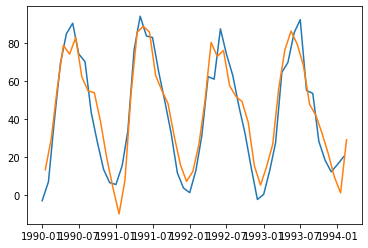

In [7]:
# Sanity check:
plt.plot(era5_dates[0:50], era5_flux['SHobs'].values[0:50,135,200])
plt.plot(dates[0:50], fullFlux['SHFLX'].values[0:50,135,200])


### Combine data into single datasets (model and obs, seperately)

In [8]:
## Combine everything into single DS: 

dsAll         = fullFlux 
#dsAll['W500'] = (('time','lat','lon'), W500)
dsAll['PBLH'] = (('time','lat','lon'), fullPBLH.PBLH)

dsAll         = xr.merge([fullCLUBB, fullWind, dsAll])
# dsAll         = xr.merge([fullCloud, fullWind, dsAll])


In [9]:
#del fullCLUBB
# #del fullWind 
del fullFlux 
del fullPBLH 
del fullWind


In [10]:
## Combine everything into single DS (ERA5): 
dsAll_era5              = era5_flux 
dsAll_era5['PBLH_cesm'] = (('time','lat','lon'), dsAll.PBLH.values)


In [11]:
## Also get indices of DJF and JJA to use later:
iMAM = np.where((dates.month>=3) & (dates.month<=5))[0]
iJJA = np.where((dates.month>=6) & (dates.month<=8))[0]
iSON = np.where((dates.month>=9) & (dates.month<=11))[0]
iDJF = np.where((dates.month==12) | (dates.month<=2))[0]

iMAM_era5 = np.where((era5_dates.month>=3) & (era5_dates.month<=5))[0]
iJJA_era5 = np.where((era5_dates.month>=6) & (era5_dates.month<=8))[0]
iJSON_era5 = np.where((era5_dates.month>=9) & (era5_dates.month<=11))[0]
iDJF_era5 = np.where((era5_dates.month==12) | (era5_dates.month<=2))[0]


### Define model flux bias

In [12]:
# Now get averages of SH and LH for CAM6 and ERA5
#   Take the bias as the difference in seasonal means? 
#   Or should the bias be the difference in monthly mean fluxes, *then* averaged up to a certain season? 

# Sanity check shows *very* little difference in where you average first: 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# SHbias = dsAll.SHFLX.values - dsAll_era5.SHobs.values 
# print(np.nanmean(SHbias[iDJF,140,260]))
# SHbias_DJF = np.nanmean(dsAll.SHFLX.values[iDJF,:,:], axis=0) - np.nanmean(dsAll_era5.SHobs.values [iDJF,:,:], axis=0)
# print(SHbias_DJF[140,260])

# So let's just get the bias on all the months, then get the mean in a season of that: 

# If we take bias as just the difference in monthly mean LHFLX and SHFLX (CAM6 - ERA5): 
SHbias = dsAll.SHFLX.values - dsAll_era5.SHobs.values 
LHbias = dsAll.LHFLX.values - dsAll_era5.LHobs.values



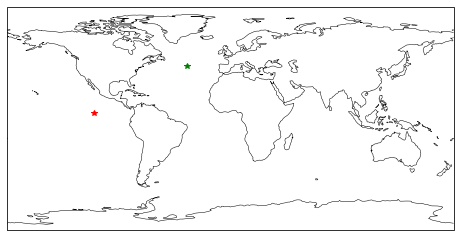

In [48]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5), subplot_kw={'projection':ccrs.PlateCarree()})

ax1.coastlines(linewidth=0.5,edgecolor='0.25')

ax1.plot(lon[200],lat[100],'r*',transform=ccrs.PlateCarree())
ax1.plot(lon[260],lat[140],'g*',transform=ccrs.PlateCarree())

ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())


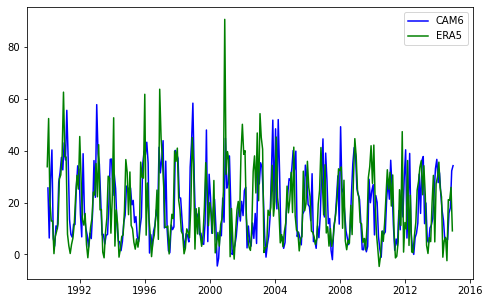

In [49]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5))

ax1.plot(dates, dsAll.SHFLX.values[:,140,260],'b-')
ax1.plot(era5_dates, dsAll_era5.SHobs.values[:,140,260],'g-')
ax1.legend(['CAM6','ERA5'])


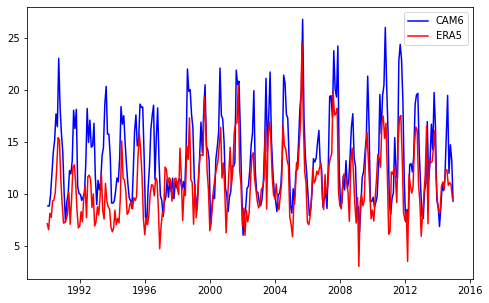

In [42]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5))

ax1.plot(dates, dsAll.SHFLX.values[:,100,200],'b-')
ax1.plot(era5_dates, dsAll_era5.SHobs.values[:,100,200],'r-')
ax1.legend(['CAM6','ERA5'])


## Begin regional analysis: 2D histograms

In [15]:
# Define regions next...
# Create 3D mask of ocean regions
RegMask = regionmask.defined_regions.ar6.ocean.mask_3D(lon, lat)

# Loop over regions... 
nRegions = len(RegMask.region.values)

# Set up bin edges for both vars
SHbias_edges = np.linspace(-30,30,51)
LHbias_edges = np.linspace(-50,50,51)
PBLH_edges   = np.linspace(300,1200,51)

PBLH = dsAll.PBLH.values


In [122]:
# # Save output 
# H_SHbiasVSpblh_DJF = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)
# H_SHbiasVSpblh_MAM = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)
# H_SHbiasVSpblh_JJA = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)
# H_SHbiasVSpblh_SON = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)

# H_LHbiasVSpblh_DJF = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)
# H_LHbiasVSpblh_MAM = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)
# H_LHbiasVSpblh_JJA = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)
# H_LHbiasVSpblh_SON = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)

# # ----- Loop over regions to get 2D histogram data ---- # 
# for iReg in range(nRegions): 
#     # Get indices of selected region 
#     rSel = RegMask.sel(region=RegMask.region[iReg])
#     rMask = np.full([len(lat),len(lon)],np.nan)
#     rMask[rSel==True] = 1 
    
#     # ---- Isolate regions of variables, flatten arrays ----- 
#     SHbias_regSel_DJF   = (np.nanmean(SHbias[iDJF,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     SHbias_regSel_MAM   = (np.nanmean(SHbias[iMAM,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     SHbias_regSel_JJA   = (np.nanmean(SHbias[iJJA,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     SHbias_regSel_SON   = (np.nanmean(SHbias[iSON,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
    
#     PBLH_regSel_DJF = (np.nanmean(PBLH[iDJF,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     PBLH_regSel_MAM = (np.nanmean(PBLH[iMAM,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     PBLH_regSel_JJA = (np.nanmean(PBLH[iJJA,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     PBLH_regSel_SON = (np.nanmean(PBLH[iSON,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
    
#     LHbias_regSel_DJF   = (np.nanmean(LHbias[iDJF,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     LHbias_regSel_MAM   = (np.nanmean(LHbias[iMAM,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     LHbias_regSel_JJA   = (np.nanmean(LHbias[iJJA,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
#     LHbias_regSel_SON   = (np.nanmean(SHbias[iSON,:,:],axis=0)*rMask).reshape([len(lon)*len(lat)])
    
#     # ----- Get 2D histogram info -----
#     H_SHbiasVSpblh_DJFtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_DJF, 
#                                                                       SHbias_regSel_DJF, 
#                                                                       bins=(PBLH_edges, SHbias_edges))
#     H_SHbiasVSpblh_MAMtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_MAM, 
#                                                                       SHbias_regSel_MAM, 
#                                                                       bins=(PBLH_edges, SHbias_edges))
#     H_SHbiasVSpblh_JJAtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_JJA, 
#                                                                       SHbias_regSel_JJA, 
#                                                                       bins=(PBLH_edges, SHbias_edges))
#     H_SHbiasVSpblh_SONtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_SON, 
#                                                                       SHbias_regSel_SON, 
#                                                                       bins=(PBLH_edges, SHbias_edges))    
    
#     H_LHbiasVSpblh_DJFtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_DJF, 
#                                                                       LHbias_regSel_DJF, 
#                                                                       bins=(PBLH_edges, LHbias_edges))
#     H_LHbiasVSpblh_MAMtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_MAM, 
#                                                                       LHbias_regSel_MAM, 
#                                                                       bins=(PBLH_edges, LHbias_edges))
#     H_LHbiasVSpblh_JJAtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_JJA, 
#                                                                       LHbias_regSel_JJA, 
#                                                                       bins=(PBLH_edges, LHbias_edges))
#     H_LHbiasVSpblh_SONtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_SON, 
#                                                                       LHbias_regSel_SON, 
#                                                                       bins=(PBLH_edges, LHbias_edges))  
    
    
#     # ----- Save all regions to large array -----
#     #    Units are as fraction of gridcells in region; x100 to get pct 
#     H_SHbiasVSpblh_DJF[iReg,:,:] = (H_SHbiasVSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
#     H_SHbiasVSpblh_MAM[iReg,:,:] = (H_SHbiasVSpblh_MAMtemp.T)/np.nansum(rMask)
#     H_SHbiasVSpblh_JJA[iReg,:,:] = (H_SHbiasVSpblh_JJAtemp.T)/np.nansum(rMask)
#     H_SHbiasVSpblh_SON[iReg,:,:] = (H_SHbiasVSpblh_SONtemp.T)/np.nansum(rMask)
    
#     H_LHbiasVSpblh_DJF[iReg,:,:] = (H_LHbiasVSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
#     H_LHbiasVSpblh_MAM[iReg,:,:] = (H_LHbiasVSpblh_MAMtemp.T)/np.nansum(rMask)
#     H_LHbiasVSpblh_JJA[iReg,:,:] = (H_LHbiasVSpblh_JJAtemp.T)/np.nansum(rMask)
#     H_LHbiasVSpblh_SON[iReg,:,:] = (H_LHbiasVSpblh_SONtemp.T)/np.nansum(rMask)
    


In [32]:
# --------------------
# Same as above, but using all times in a season as a separate point, so no averaging. 
# --------------------

# Save output 
H_SHbiasVSpblh_DJF = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)
H_SHbiasVSpblh_MAM = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)
H_SHbiasVSpblh_JJA = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)
H_SHbiasVSpblh_SON = np.full([nRegions,len(SHbias_edges)-1,len(PBLH_edges)-1], np.nan)

H_LHbiasVSpblh_DJF = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)
H_LHbiasVSpblh_MAM = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)
H_LHbiasVSpblh_JJA = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)
H_LHbiasVSpblh_SON = np.full([nRegions,len(LHbias_edges)-1,len(PBLH_edges)-1], np.nan)

# ----- Loop over regions to get 2D histogram data ---- # 
for iReg in range(nRegions): 
    # Get indices of selected region 
    rSel = RegMask.sel(region=RegMask.region[iReg])
    rMask = np.full([len(lat),len(lon)],np.nan)
    rMask[rSel==True] = 1 
    rMask_3d = rMask[np.newaxis,:,:]
    
    
    # ---- Isolate regions of variables, flatten arrays ----- 
    SHbias_regSel_DJF   = (SHbias[iDJF,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iDJF)])
    SHbias_regSel_MAM   = (SHbias[iMAM,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iMAM)])
    SHbias_regSel_JJA   = (SHbias[iJJA,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iJJA)])
    SHbias_regSel_SON   = (SHbias[iSON,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iSON)])
    
    PBLH_regSel_DJF = (PBLH[iDJF,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iDJF)])
    PBLH_regSel_MAM = (PBLH[iMAM,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iMAM)])
    PBLH_regSel_JJA = (PBLH[iJJA,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iJJA)])
    PBLH_regSel_SON = (PBLH[iSON,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iSON)])
    
    LHbias_regSel_DJF   = (LHbias[iDJF,:,:]*rMask).reshape([len(lon)*len(lat)*len(iDJF)])
    LHbias_regSel_MAM   = (LHbias[iMAM,:,:]*rMask).reshape([len(lon)*len(lat)*len(iMAM)])
    LHbias_regSel_JJA   = (LHbias[iJJA,:,:]*rMask).reshape([len(lon)*len(lat)*len(iJJA)])
    LHbias_regSel_SON   = (LHbias[iSON,:,:]*rMask).reshape([len(lon)*len(lat)*len(iSON)])
    
    # ----- Get 2D histogram info -----
    H_SHbiasVSpblh_DJFtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_DJF, 
                                                                      SHbias_regSel_DJF, 
                                                                      bins=(PBLH_edges, SHbias_edges))
    H_SHbiasVSpblh_MAMtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_MAM, 
                                                                      SHbias_regSel_MAM, 
                                                                      bins=(PBLH_edges, SHbias_edges))
    H_SHbiasVSpblh_JJAtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_JJA, 
                                                                      SHbias_regSel_JJA, 
                                                                      bins=(PBLH_edges, SHbias_edges))
    H_SHbiasVSpblh_SONtemp, PBLH_edges, SHbias_edges = np.histogram2d(PBLH_regSel_SON, 
                                                                      SHbias_regSel_SON, 
                                                                      bins=(PBLH_edges, SHbias_edges))    
    
    H_LHbiasVSpblh_DJFtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_DJF, 
                                                                      LHbias_regSel_DJF, 
                                                                      bins=(PBLH_edges, LHbias_edges))
    H_LHbiasVSpblh_MAMtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_MAM, 
                                                                      LHbias_regSel_MAM, 
                                                                      bins=(PBLH_edges, LHbias_edges))
    H_LHbiasVSpblh_JJAtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_JJA, 
                                                                      LHbias_regSel_JJA, 
                                                                      bins=(PBLH_edges, LHbias_edges))
    H_LHbiasVSpblh_SONtemp, PBLH_edges, LHbias_edges = np.histogram2d(PBLH_regSel_SON, 
                                                                      LHbias_regSel_SON, 
                                                                      bins=(PBLH_edges, LHbias_edges))  
    
    
    # ----- Save all regions to large array -----
    #    Units are as fraction of gridcells in region; x100 to get pct 
    H_SHbiasVSpblh_DJF[iReg,:,:] = (H_SHbiasVSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
    H_SHbiasVSpblh_MAM[iReg,:,:] = (H_SHbiasVSpblh_MAMtemp.T)/np.nansum(rMask)
    H_SHbiasVSpblh_JJA[iReg,:,:] = (H_SHbiasVSpblh_JJAtemp.T)/np.nansum(rMask)
    H_SHbiasVSpblh_SON[iReg,:,:] = (H_SHbiasVSpblh_SONtemp.T)/np.nansum(rMask)
    
    H_LHbiasVSpblh_DJF[iReg,:,:] = (H_LHbiasVSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
    H_LHbiasVSpblh_MAM[iReg,:,:] = (H_LHbiasVSpblh_MAMtemp.T)/np.nansum(rMask)
    H_LHbiasVSpblh_JJA[iReg,:,:] = (H_LHbiasVSpblh_JJAtemp.T)/np.nansum(rMask)
    H_LHbiasVSpblh_SON[iReg,:,:] = (H_LHbiasVSpblh_SONtemp.T)/np.nansum(rMask)
    



## Plot histograms

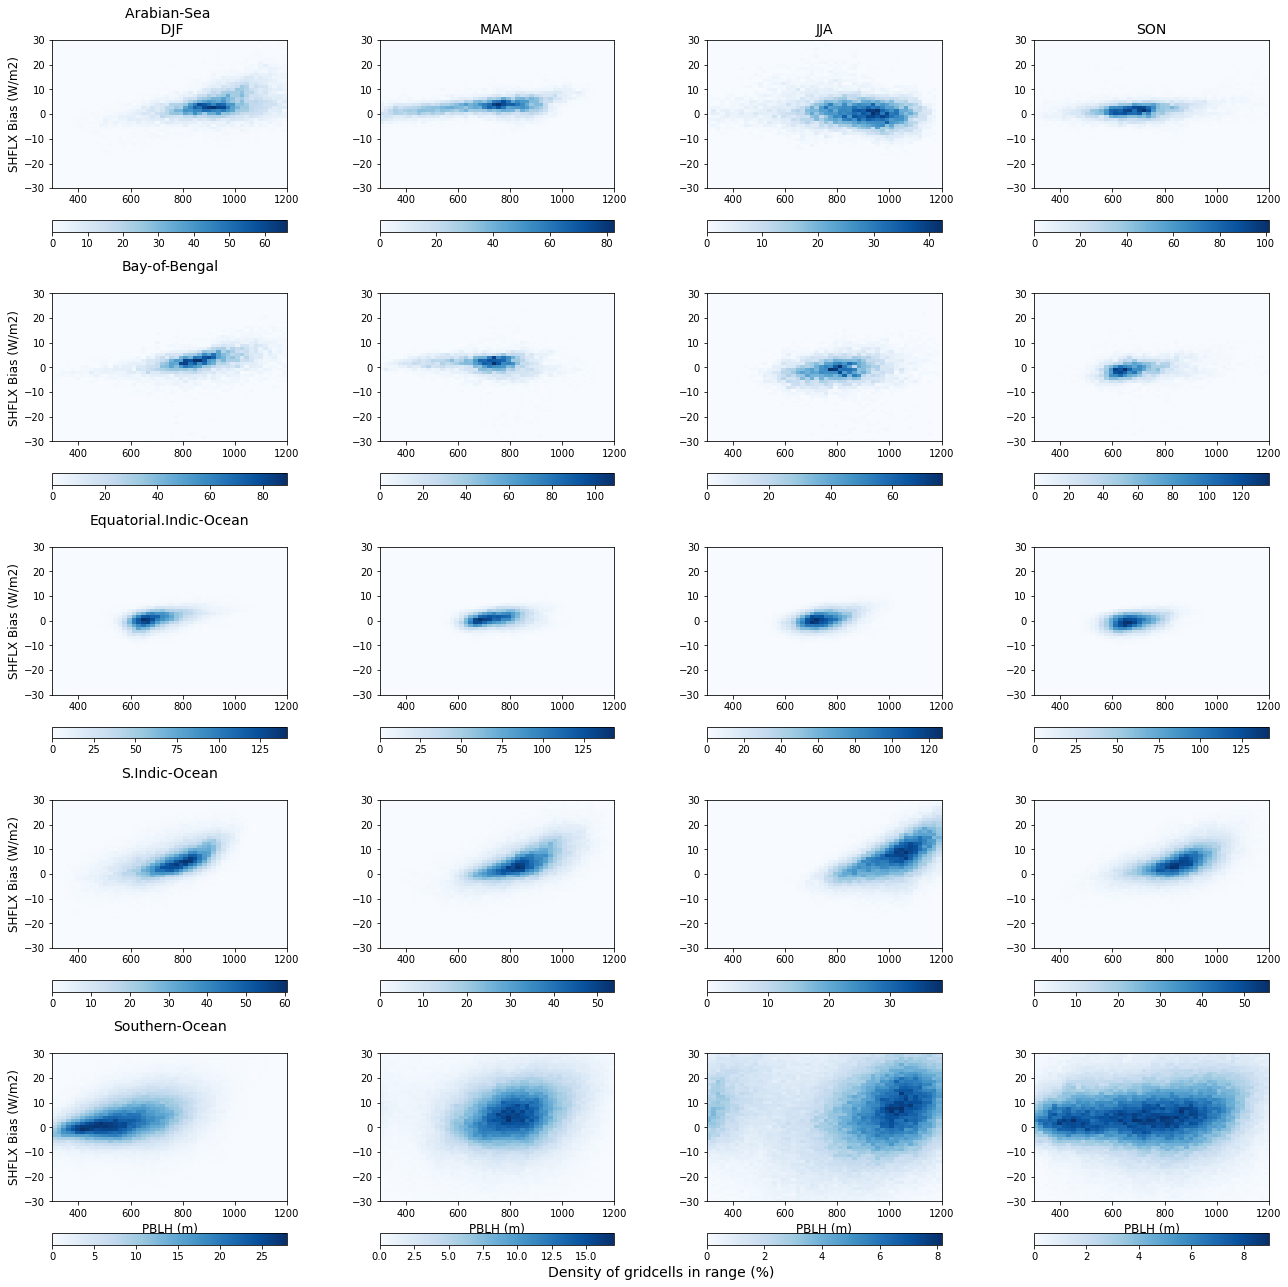

In [21]:
# Set up figure that plots U vs. LHFLX
fig, axs = plt.subplots(5,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(PBLH_edges,SHbias_edges)

regOffset = 5*2     # To change group of regions being plotted (increments of 4) 
pltInd    = 0       # To change plot index by season as well as region 

for iReg in range(5):
    
    # Plot data ----------------------------------------------
    
    # Plot DJF 
    pPlot = axs[pltInd+0].pcolormesh(X,Y, 100.0*H_SHbiasVSpblh_DJF[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])
    
    # Plot MAM 
    pPlot=axs[pltInd+1].pcolormesh(X,Y, 100*H_SHbiasVSpblh_MAM[iReg+regOffset,:,:],cmap='Blues')
    # Use colorbar label only on bottom 
    if iReg==4:
        cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
        cb.set_label('Density of gridcells in range (%)',x=1.2,fontsize=14)
    else:
        fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])

    # Plot JJA 
    pPlot=axs[pltInd+2].pcolormesh(X,Y, 100*H_SHbiasVSpblh_JJA[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+2])
    
    
    # Plot SON 
    pPlot=axs[pltInd+3].pcolormesh(X,Y, 100*H_SHbiasVSpblh_SON[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+3])
    
    # ----------------------------------------------

    # Set plot titles 
    if iReg==0:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
        axs[pltInd+1].set_title('MAM',fontsize=14)
        axs[pltInd+2].set_title('JJA',fontsize=14)
        axs[pltInd+3].set_title('SON',fontsize=14)
    else:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)
        
    # Set axis labels only for outside plots 
    axs[pltInd+0].set_ylabel('SHFLX Bias (W/m2)',fontsize=12)
    
    if iReg==4: 
        axs[pltInd+0].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+1].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+2].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+3].set_xlabel('PBLH (m)', fontsize=12)  

    plt.tight_layout(h_pad=1)
    # Increment plot index for next region 
    pltInd = pltInd+4
    

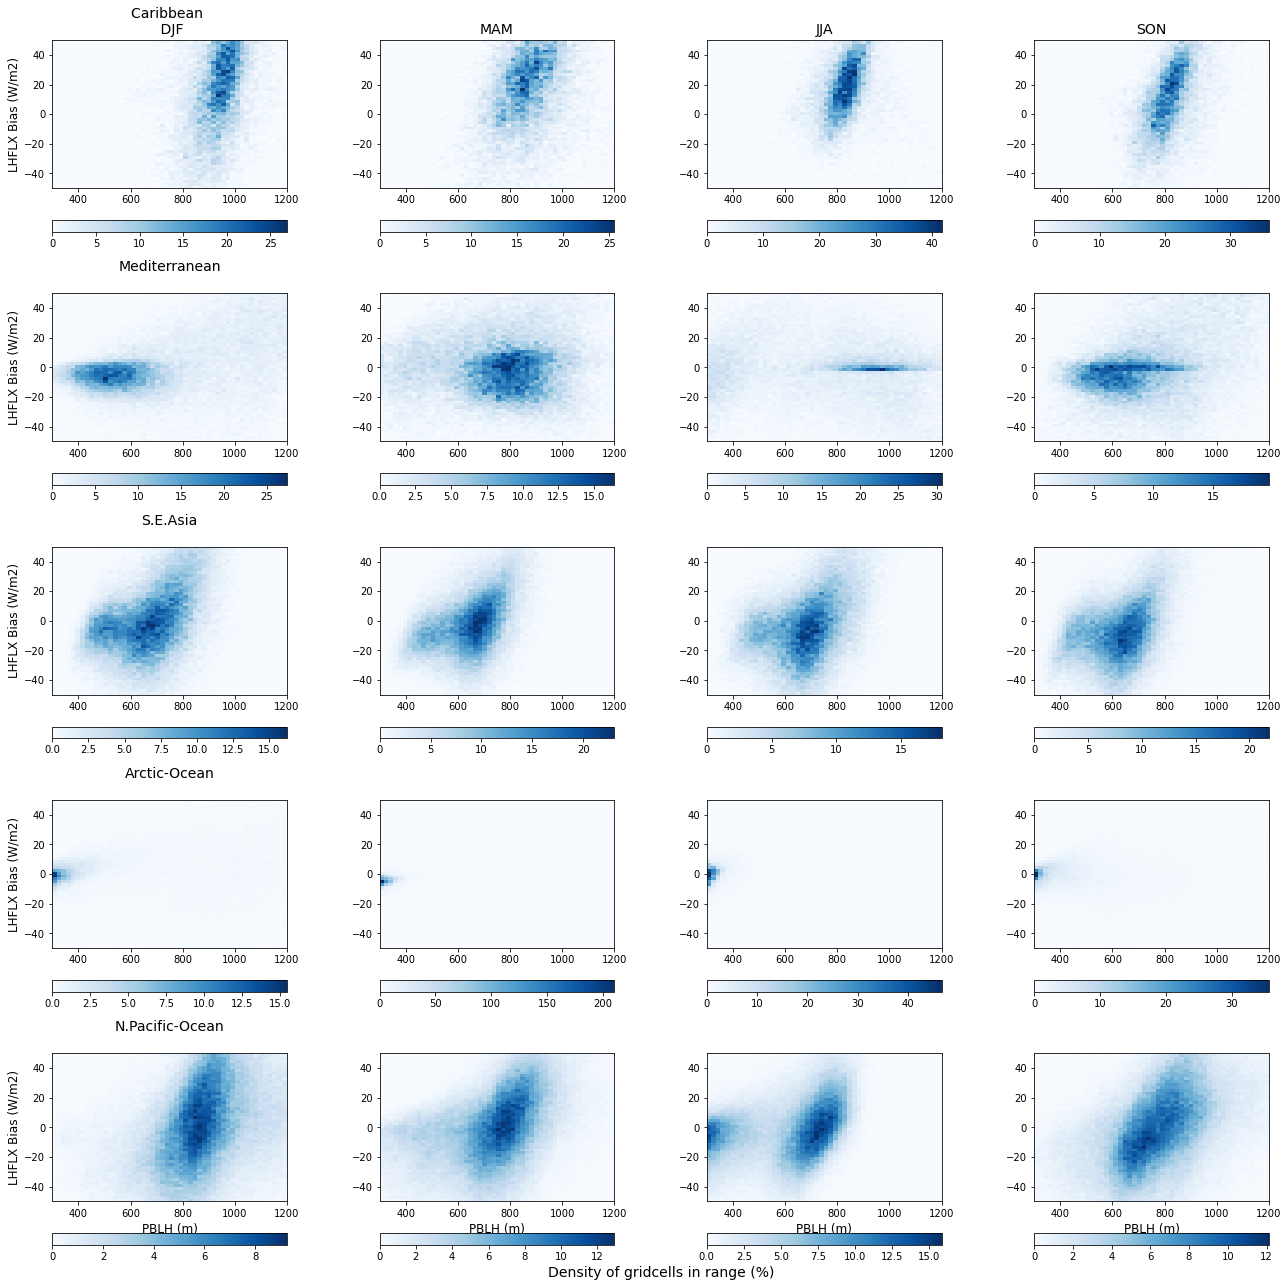

In [54]:
# Set up figure that plots U vs. LHFLX
fig, axs = plt.subplots(5,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(PBLH_edges,LHbias_edges)

regOffset = 5*0     # To change group of regions being plotted (increments of 4) 
pltInd    = 0       # To change plot index by season as well as region 

for iReg in range(5):
    
    # Plot data ----------------------------------------------
    
    # Plot DJF 
    pPlot = axs[pltInd+0].pcolormesh(X,Y, 100.0*H_LHbiasVSpblh_DJF[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])
    
    # Plot MAM 
    pPlot=axs[pltInd+1].pcolormesh(X,Y, 100*H_LHbiasVSpblh_MAM[iReg+regOffset,:,:],cmap='Blues')
    # Use colorbar label only on bottom 
    if iReg==4:
        cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
        cb.set_label('Density of gridcells in range (%)',x=1.2,fontsize=14)
    else:
        fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])

    # Plot JJA 
    pPlot=axs[pltInd+2].pcolormesh(X,Y, 100*H_LHbiasVSpblh_JJA[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+2])
    
    
    # Plot SON 
    pPlot=axs[pltInd+3].pcolormesh(X,Y, 100*H_LHbiasVSpblh_SON[iReg+regOffset,:,:],cmap='Blues')
    fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+3])
    
    # ----------------------------------------------

    # Set plot titles 
    if iReg==0:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
        axs[pltInd+1].set_title('MAM',fontsize=14)
        axs[pltInd+2].set_title('JJA',fontsize=14)
        axs[pltInd+3].set_title('SON',fontsize=14)
    else:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)
        
    # Set axis labels only for outside plots 
    axs[pltInd+0].set_ylabel('LHFLX Bias (W/m2)',fontsize=12)
    
    if iReg==4: 
        axs[pltInd+0].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+1].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+2].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+3].set_xlabel('PBLH (m)', fontsize=12)  

    plt.tight_layout(h_pad=1)
    # Increment plot index for next region 
    pltInd = pltInd+4
    

## Maybe scatter plots though?

In [13]:
import warnings
warnings.filterwarnings("ignore")

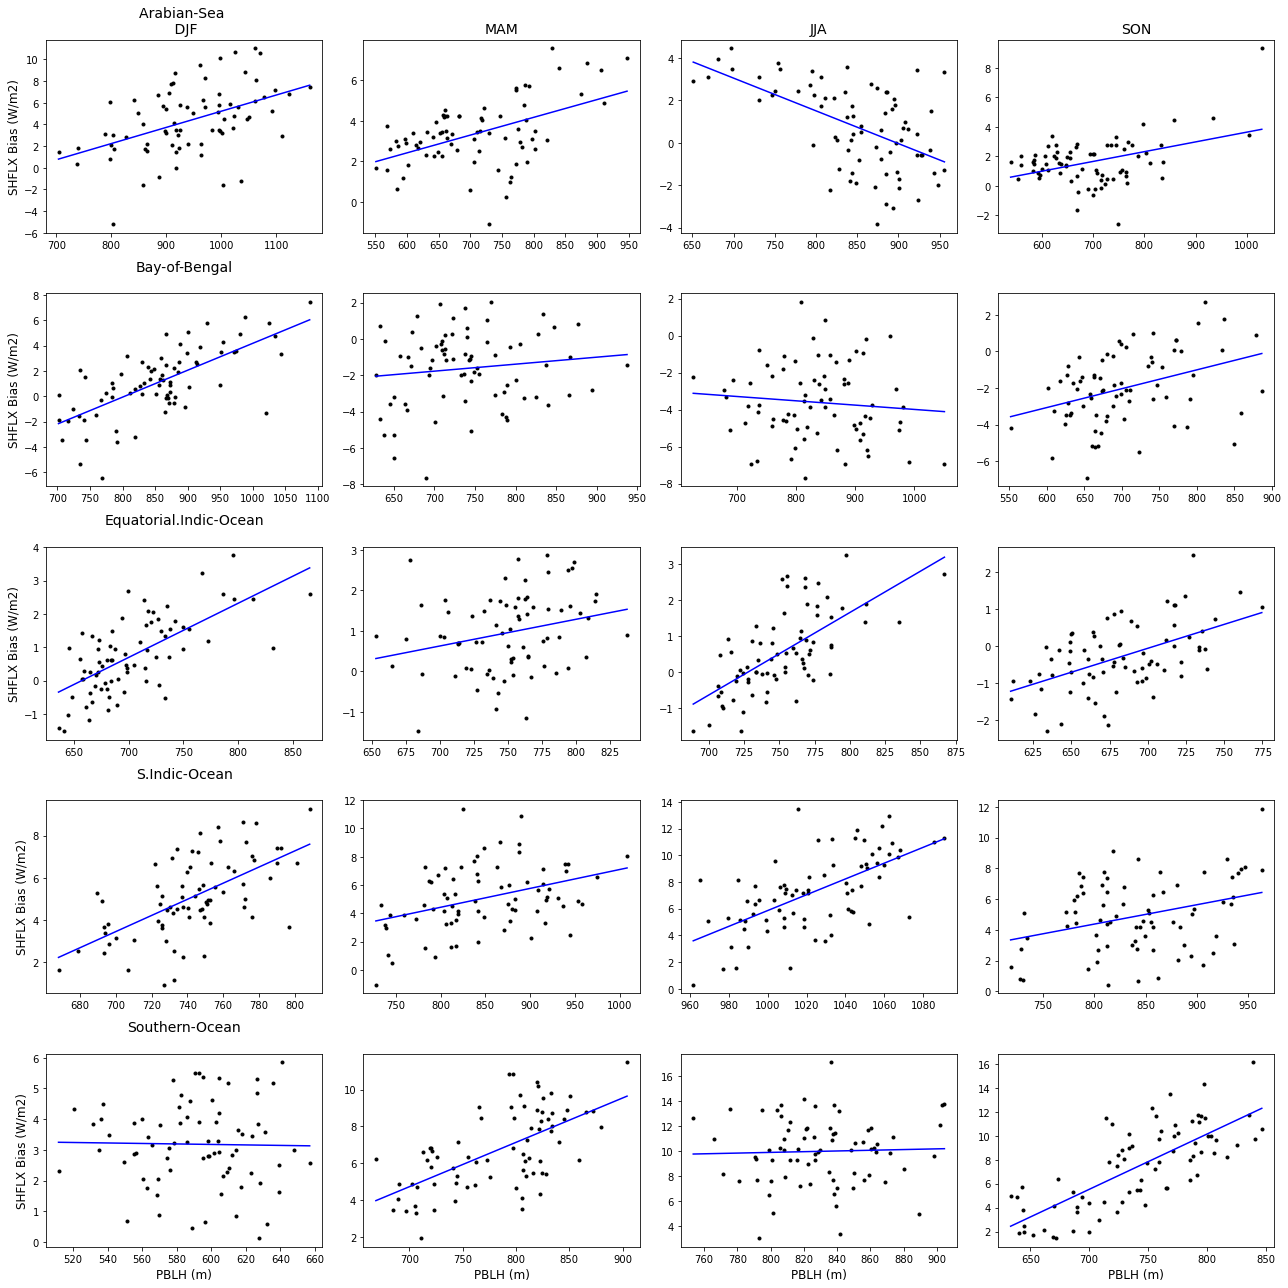

In [171]:
# Set up figure that plots U vs. LHFLX
fig, axs = plt.subplots(5,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(PBLH_edges,SHbias_edges)

regOffset = 5*2     # To change group of regions being plotted (increments of 4) 
pltInd    = 0       # To change plot index by season as well as region 

for iReg in range(5):
    
    # Select a region: 
    # - - - - - - - - - - 
    rSel = RegMask.sel(region=RegMask.region[iReg+regOffset])
    rMask = np.full([len(lat),len(lon)],np.nan)
    rMask[rSel==True] = 1 

    # Make mask 3D so that it can be multiplied with actual arrays of PBLH and bias...
    rMask_3d = rMask[np.newaxis,:,:]

#     SHbias_MAM_region = rMask_3d * SHbias[iMAM,:,:]
#     PBLH_MAM_region   = rMask_3d * PBLH[iMAM,:,:]
#     plt.plot(np.nanmean(np.nanmean(PBLH_MAM_region,axis=1),axis=1), 
#          np.nanmean(np.nanmean(SHbias_MAM_region,axis=1),axis=1), 
#          'k.')
    
    # Plot data ----------------------------------------------
    
    # Plot DJF 
    axs[pltInd+0].plot(np.nanmean(np.nanmean((rMask_3d * PBLH[iDJF,:,:]),axis=1),axis=1),
                       np.nanmean(np.nanmean((rMask_3d * SHbias[iDJF,:,:]),axis=1),axis=1),
                       'k.')
    x = np.nanmean(np.nanmean((rMask_3d * PBLH[iDJF,:,:]),axis=1),axis=1)
    y = np.nanmean(np.nanmean((rMask_3d * SHbias[iDJF,:,:]),axis=1),axis=1)
    axs[pltInd+0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')
    
    # Plot MAM 
    axs[pltInd+1].plot(np.nanmean(np.nanmean((rMask_3d * PBLH[iMAM,:,:]),axis=1),axis=1),
                       np.nanmean(np.nanmean((rMask_3d * SHbias[iMAM,:,:]),axis=1),axis=1),
                       'k.')
    x = np.nanmean(np.nanmean((rMask_3d * PBLH[iMAM,:,:]),axis=1),axis=1)
    y = np.nanmean(np.nanmean((rMask_3d * SHbias[iMAM,:,:]),axis=1),axis=1)
    axs[pltInd+1].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')

    # Plot JJA 
    axs[pltInd+2].plot(np.nanmean(np.nanmean((rMask_3d * PBLH[iJJA,:,:]),axis=1),axis=1),
                       np.nanmean(np.nanmean((rMask_3d * SHbias[iJJA,:,:]),axis=1),axis=1),
                       'k.')
    x = np.nanmean(np.nanmean((rMask_3d * PBLH[iJJA,:,:]),axis=1),axis=1)
    y = np.nanmean(np.nanmean((rMask_3d * SHbias[iJJA,:,:]),axis=1),axis=1)
    axs[pltInd+2].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')
    
    # Plot SON 
    axs[pltInd+3].plot(np.nanmean(np.nanmean((rMask_3d * PBLH[iSON,:,:]),axis=1),axis=1),
                       np.nanmean(np.nanmean((rMask_3d * SHbias[iSON,:,:]),axis=1),axis=1),
                       'k.')
    x = np.nanmean(np.nanmean((rMask_3d * PBLH[iSON,:,:]),axis=1),axis=1)
    y = np.nanmean(np.nanmean((rMask_3d * SHbias[iSON,:,:]),axis=1),axis=1)
    axs[pltInd+3].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')
    
    # ----------------------------------------------

    # Set plot titles 
    if iReg==0:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
        axs[pltInd+1].set_title('MAM',fontsize=14)
        axs[pltInd+2].set_title('JJA',fontsize=14)
        axs[pltInd+3].set_title('SON',fontsize=14)
    else:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)
        
    # Set axis labels only for outside plots 
    axs[pltInd+0].set_ylabel('SHFLX Bias (W/m2)',fontsize=12)
    
    if iReg==4: 
        axs[pltInd+0].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+1].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+2].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+3].set_xlabel('PBLH (m)', fontsize=12)  

    plt.tight_layout(h_pad=1)
    # Increment plot index for next region 
    pltInd = pltInd+4
    


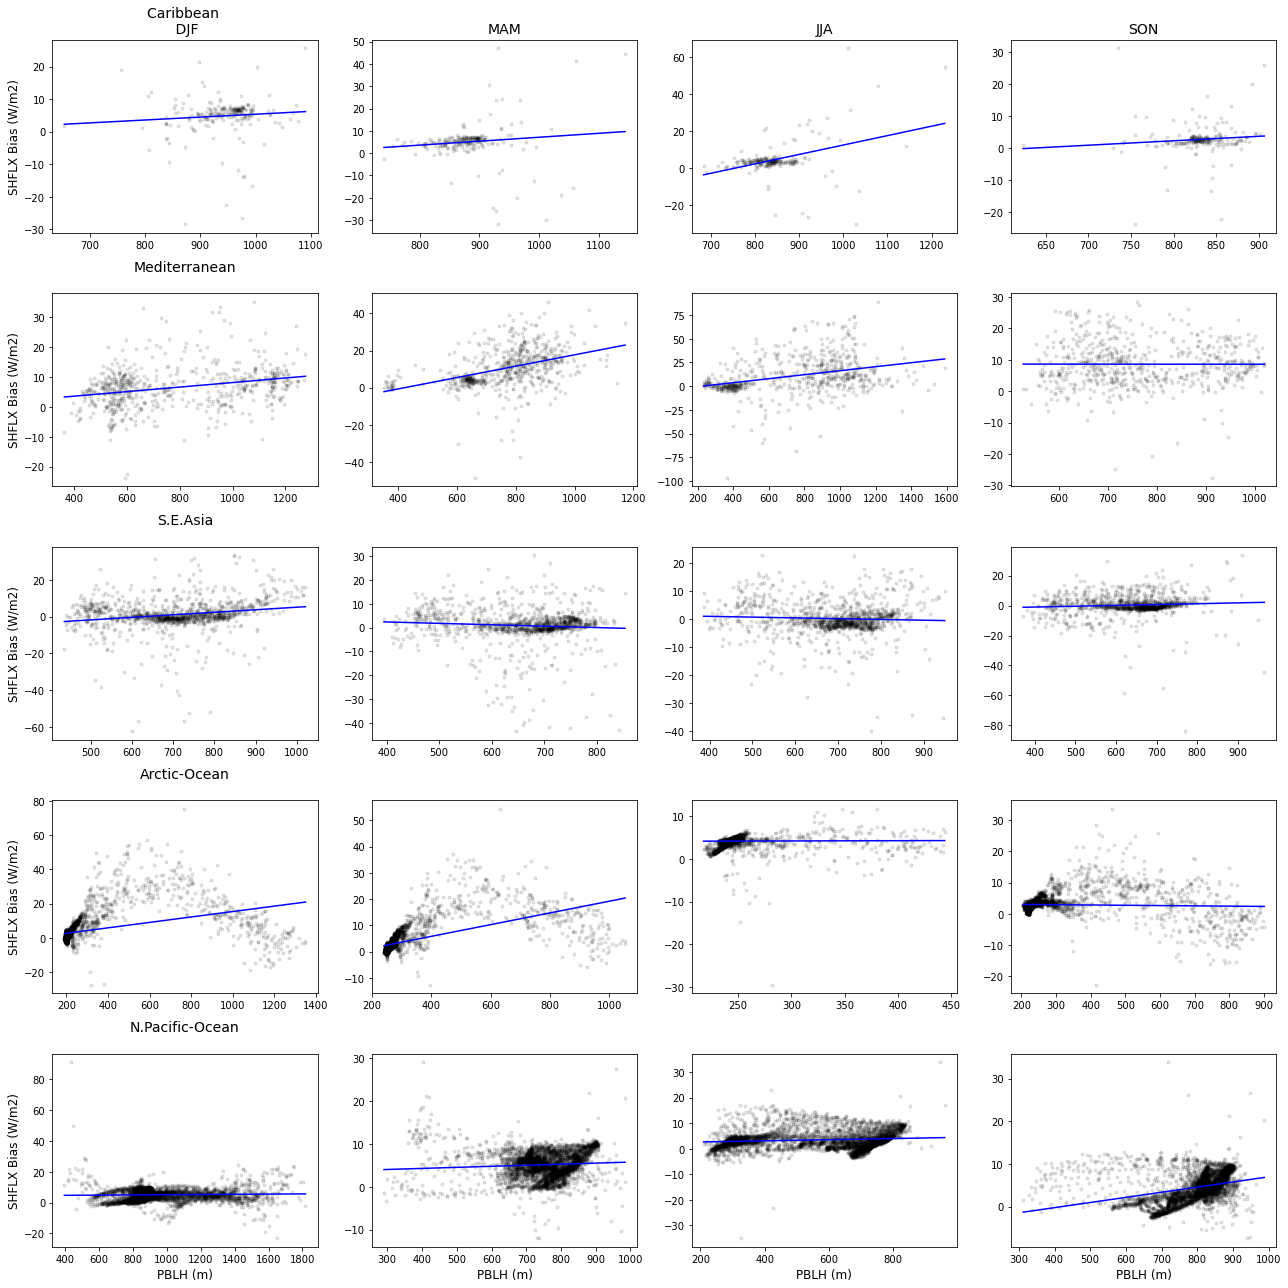

In [178]:
# Set up figure that plots U vs. LHFLX
fig, axs = plt.subplots(5,4, figsize=(18, 18))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X,Y = np.meshgrid(PBLH_edges,SHbias_edges)

regOffset = 5*0     # To change group of regions being plotted (increments of 4) 
pltInd    = 0       # To change plot index by season as well as region 

for iReg in range(5):
    
    # Select a region: 
    # - - - - - - - - - - 
    rSel = RegMask.sel(region=RegMask.region[iReg+regOffset])
    rMask = np.full([len(lat),len(lon)],np.nan)
    rMask[rSel==True] = 1 

    # Make mask 3D so that it can be multiplied with actual arrays of PBLH and bias...
    rMask_3d = rMask[np.newaxis,:,:]

#     SHbias_MAM_region = rMask_3d * SHbias[iMAM,:,:]
#     PBLH_MAM_region   = rMask_3d * PBLH[iMAM,:,:]
#     plt.plot(np.nanmean(np.nanmean(PBLH_MAM_region,axis=1),axis=1), 
#          np.nanmean(np.nanmean(SHbias_MAM_region,axis=1),axis=1), 
#          'k.')
    
    # Plot data ----------------------------------------------
    
    # Plot DJF 
    axs[pltInd+0].plot(np.nanmean((rMask_3d * PBLH[iDJF,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       np.nanmean((rMask_3d * SHbias[iDJF,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       'k.',alpha=0.1)
    x = np.squeeze(np.nanmean((rMask_3d * PBLH[iDJF,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    y = np.squeeze(np.nanmean((rMask_3d * SHbias[iDJF,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    axs[pltInd+0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')
    
    # Plot MAM 
    axs[pltInd+1].plot(np.nanmean((rMask_3d * PBLH[iMAM,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       np.nanmean((rMask_3d * SHbias[iMAM,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       'k.',alpha=0.1)
    x = np.squeeze(np.nanmean((rMask_3d * PBLH[iMAM,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    y = np.squeeze(np.nanmean((rMask_3d * SHbias[iMAM,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    axs[pltInd+1].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')

    # Plot JJA 
    axs[pltInd+2].plot(np.nanmean((rMask_3d * PBLH[iJJA,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       np.nanmean((rMask_3d * SHbias[iJJA,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       'k.',alpha=0.1)
    x = np.squeeze(np.nanmean((rMask_3d * PBLH[iJJA,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    y = np.squeeze(np.nanmean((rMask_3d * SHbias[iJJA,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    axs[pltInd+2].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')
    
    # Plot SON 
    axs[pltInd+3].plot(np.nanmean((rMask_3d * PBLH[iSON,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       np.nanmean((rMask_3d * SHbias[iSON,:,:]),axis=0).reshape([len(lat)*len(lon)]),
                       'k.',alpha=0.1)
    x = np.squeeze(np.nanmean((rMask_3d * PBLH[iSON,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    y = np.squeeze(np.nanmean((rMask_3d * SHbias[iSON,:,:]),axis=0).reshape([len(lat)*len(lon)]))
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    axs[pltInd+3].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'b-')
    
    # ----------------------------------------------

    # Set plot titles 
    if iReg==0:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
        axs[pltInd+1].set_title('MAM',fontsize=14)
        axs[pltInd+2].set_title('JJA',fontsize=14)
        axs[pltInd+3].set_title('SON',fontsize=14)
    else:
        axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)
        
    # Set axis labels only for outside plots 
    axs[pltInd+0].set_ylabel('SHFLX Bias (W/m2)',fontsize=12)
    
    if iReg==4: 
        axs[pltInd+0].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+1].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+2].set_xlabel('PBLH (m)', fontsize=12)
        axs[pltInd+3].set_xlabel('PBLH (m)', fontsize=12)  

    plt.tight_layout(h_pad=1)
    # Increment plot index for next region 
    pltInd = pltInd+4
    

## CLUBB variables in a region? 

In [73]:
dsAll


<xarray.Dataset>
Dimensions:        (ilev: 33, lat: 192, lev: 32, lon: 288, nbnd: 2, time: 300)
Coordinates:
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time           (time) object 1990-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    hyam           (time, lev) float64 0.003643 0.007595 ... 0.001989 0.0
    hybm           (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    P0             (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai           (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.0 0.0
    hybi           (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9636 0.9851 1.0
    time_bnds      (time, nbnd) object 1990-01-01 00:00:00 ... 2015-01-01 00:...
    PS             (time, lat, lon) float32 68861.125 68861.125 ... 101900.73
    RTP2_CLUBB     (time, ilev, lat, lon) float32 1e-13 1e-13 ... 4.0091823e-09
    RVMTEND_CLUBB  (time, lev, lat, lon) float32 0.0 0.0 ... -8.20141e-10
    STEND_CLUBB    (time, lev, lat, lon) float32 -4.4730527e-06 ... -0.015226418
    THLP2_CLUBB    (time, ilev, lat, lon) float32 1e-04 1e-04 ... 0.008180851
    UPWP_CLUBB     (time, ilev, lat, lon) float32 0.0 0.0 ... 0.04287921
    UTEND_CLUBB    (time, lev, lat, lon) float32 2.029806e-11 ... 0.0003335456
    WPTHLP_CLUBB   (time, ilev, lat, lon) float32 0.0 0.0 ... -6.40898
    UP2_CLUBB      (time, ilev, lat, lon) float32 0.0004 0.0004 ... 0.19080701
    VP2_CLUBB      (time, ilev, lat, lon) float32 0.0004 0.0004 ... 0.19080701
    WP2_CLUBB      (time, ilev, lat, lon) float32 0.0004 0.0004 ... 0.095409386
    WP3_CLUBB      (time, ilev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LHFLX          (time, lat, lon) float32 -0.5068986 -0.5069128 ... -1.4939332
    SHFLX          (time, lat, lon) float32 -2.3802972 -2.380359 ... -6.3648434
    PBLH           (time, lat, lon) float32 238.05 238.04971 ... 188.43504

In [80]:
# Narrow in on the S. Pacific first? 

iReg = np.where(RegMask.names=='S.Pacific-Ocean')[0]
# Get indices of selected region 
rSel = RegMask.sel(region=RegMask.region[iReg])
rMask = np.full([len(lat),len(lon)],np.nan)
rMask[rSel==True] = 1 
rMask_3d = rMask[np.newaxis,:,:]

    

In [276]:
# Set up bin edges for both vars
RTP2_edges   = np.linspace(-1e-6,6e-6,51)
THLP2_edges  = np.linspace(1e-4,1e-2,51)
WP2_edges    = np.linspace(1e-2, 0.8, 51)
UP2_edges    = np.linspace(1e-2, 1.0, 51)
PBLH_edges   = np.linspace(300,1200,51)

sfcRTP2  = dsAll.RTP2_CLUBB.values[:,-1,:,:]
sfcTHLP2 = dsAll.THLP2_CLUBB.values[:,-1,:,:]
sfcWP2   = dsAll.WP2_CLUBB.values[:,-1,:,:]
sfcUP2   = dsAll.UP2_CLUBB.values[:,-1,:,:]
sfcWP3   = dsAll.WP3_CLUBB.values[:,-2,:,:] 
sfcSTEND = dsAll.STEND_CLUBB.values[:,-1,:,:]
sfcRVMTEND = dsAll.RVMTEND_CLUBB.values[:,-1,:,:]
sfcUPWP    = dsAll.UPWP_CLUBB.values[:,-1,:,:]


In [118]:
# Save output 
H_RTP2VSpblh_DJF = np.full([len(RTP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_RTP2VSpblh_MAM = np.full([len(RTP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_RTP2VSpblh_JJA = np.full([len(RTP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_RTP2VSpblh_SON = np.full([len(RTP2_edges)-1,len(PBLH_edges)-1], np.nan)

H_THLP2VSpblh_DJF = np.full([len(THLP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_THLP2VSpblh_MAM = np.full([len(THLP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_THLP2VSpblh_JJA = np.full([len(THLP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_THLP2VSpblh_SON = np.full([len(THLP2_edges)-1,len(PBLH_edges)-1], np.nan)

H_WP2VSpblh_DJF = np.full([len(WP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_WP2VSpblh_MAM = np.full([len(WP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_WP2VSpblh_JJA = np.full([len(WP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_WP2VSpblh_SON = np.full([len(WP2_edges)-1,len(PBLH_edges)-1], np.nan)

H_UP2VSpblh_DJF = np.full([len(UP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_UP2VSpblh_MAM = np.full([len(UP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_UP2VSpblh_JJA = np.full([len(UP2_edges)-1,len(PBLH_edges)-1], np.nan)
H_UP2VSpblh_SON = np.full([len(UP2_edges)-1,len(PBLH_edges)-1], np.nan)

# ---- Isolate regions of variables, flatten arrays ----- 
RTP2_regSel_DJF   = (sfcRTP2[iDJF,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iDJF)])
RTP2_regSel_MAM   = (sfcRTP2[iMAM,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iMAM)])
RTP2_regSel_JJA   = (sfcRTP2[iJJA,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iJJA)])
RTP2_regSel_SON   = (sfcRTP2[iSON,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iSON)])

PBLH_regSel_DJF = (PBLH[iDJF,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iDJF)])
PBLH_regSel_MAM = (PBLH[iMAM,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iMAM)])
PBLH_regSel_JJA = (PBLH[iJJA,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iJJA)])
PBLH_regSel_SON = (PBLH[iSON,:,:]*rMask_3d).reshape([len(lon)*len(lat)*len(iSON)])

THLP2_regSel_DJF   = (sfcTHLP2[iDJF,:,:]*rMask).reshape([len(lon)*len(lat)*len(iDJF)])
THLP2_regSel_MAM   = (sfcTHLP2[iMAM,:,:]*rMask).reshape([len(lon)*len(lat)*len(iMAM)])
THLP2_regSel_JJA   = (sfcTHLP2[iJJA,:,:]*rMask).reshape([len(lon)*len(lat)*len(iJJA)])
THLP2_regSel_SON   = (sfcTHLP2[iSON,:,:]*rMask).reshape([len(lon)*len(lat)*len(iSON)])

WP2_regSel_DJF   = (sfcWP2[iDJF,:,:]*rMask).reshape([len(lon)*len(lat)*len(iDJF)])
WP2_regSel_MAM   = (sfcWP2[iMAM,:,:]*rMask).reshape([len(lon)*len(lat)*len(iMAM)])
WP2_regSel_JJA   = (sfcWP2[iJJA,:,:]*rMask).reshape([len(lon)*len(lat)*len(iJJA)])
WP2_regSel_SON   = (sfcWP2[iSON,:,:]*rMask).reshape([len(lon)*len(lat)*len(iSON)])

UP2_regSel_DJF   = (sfcUP2[iDJF,:,:]*rMask).reshape([len(lon)*len(lat)*len(iDJF)])
UP2_regSel_MAM   = (sfcUP2[iMAM,:,:]*rMask).reshape([len(lon)*len(lat)*len(iMAM)])
UP2_regSel_JJA   = (sfcUP2[iJJA,:,:]*rMask).reshape([len(lon)*len(lat)*len(iJJA)])
UP2_regSel_SON   = (sfcUP2[iSON,:,:]*rMask).reshape([len(lon)*len(lat)*len(iSON)])


# ----- Get 2D histogram info -----
H_RTP2VSpblh_DJFtemp, PBLH_edges, RTP2_edges = np.histogram2d(PBLH_regSel_DJF, 
                                                                  RTP2_regSel_DJF, 
                                                                  bins=(PBLH_edges, RTP2_edges))
H_RTP2VSpblh_MAMtemp, PBLH_edges, RTP2_edges = np.histogram2d(PBLH_regSel_MAM, 
                                                                  RTP2_regSel_MAM, 
                                                                  bins=(PBLH_edges, RTP2_edges))
H_RTP2VSpblh_JJAtemp, PBLH_edges, RTP2_edges = np.histogram2d(PBLH_regSel_JJA, 
                                                                  RTP2_regSel_JJA, 
                                                                  bins=(PBLH_edges, RTP2_edges))
H_RTP2VSpblh_SONtemp, PBLH_edges, RTP2_edges = np.histogram2d(PBLH_regSel_SON, 
                                                                  RTP2_regSel_SON, 
                                                                  bins=(PBLH_edges, RTP2_edges))    
    
    
H_THLP2VSpblh_DJFtemp, PBLH_edges, THLP2_edges = np.histogram2d(PBLH_regSel_DJF, 
                                                                  THLP2_regSel_DJF, 
                                                                  bins=(PBLH_edges, THLP2_edges))
H_THLP2VSpblh_MAMtemp, PBLH_edges, THLP2_edges = np.histogram2d(PBLH_regSel_MAM, 
                                                                  THLP2_regSel_MAM, 
                                                                  bins=(PBLH_edges, THLP2_edges))
H_THLP2VSpblh_JJAtemp, PBLH_edges, THLP2_edges = np.histogram2d(PBLH_regSel_JJA, 
                                                                  THLP2_regSel_JJA, 
                                                                  bins=(PBLH_edges, THLP2_edges))
H_THLP2VSpblh_SONtemp, PBLH_edges, THLP2_edges = np.histogram2d(PBLH_regSel_SON, 
                                                                  THLP2_regSel_SON, 
                                                                  bins=(PBLH_edges, THLP2_edges))  
    
    
H_WP2VSpblh_DJFtemp, PBLH_edges, WP2_edges = np.histogram2d(PBLH_regSel_DJF, 
                                                                  WP2_regSel_DJF, 
                                                                  bins=(PBLH_edges, WP2_edges))
H_WP2VSpblh_MAMtemp, PBLH_edges, WP2_edges = np.histogram2d(PBLH_regSel_MAM, 
                                                                  WP2_regSel_MAM, 
                                                                  bins=(PBLH_edges, WP2_edges))
H_WP2VSpblh_JJAtemp, PBLH_edges, WP2_edges = np.histogram2d(PBLH_regSel_JJA, 
                                                                  WP2_regSel_JJA, 
                                                                  bins=(PBLH_edges, WP2_edges))
H_WP2VSpblh_SONtemp, PBLH_edges, WP2_edges = np.histogram2d(PBLH_regSel_SON, 
                                                                  WP2_regSel_SON, 
                                                                  bins=(PBLH_edges, WP2_edges))  


H_UP2VSpblh_DJFtemp, PBLH_edges, UP2_edges = np.histogram2d(PBLH_regSel_DJF, 
                                                                  UP2_regSel_DJF, 
                                                                  bins=(PBLH_edges, UP2_edges))
H_UP2VSpblh_MAMtemp, PBLH_edges, UP2_edges = np.histogram2d(PBLH_regSel_MAM, 
                                                                  UP2_regSel_MAM, 
                                                                  bins=(PBLH_edges, UP2_edges))
H_UP2VSpblh_JJAtemp, PBLH_edges, UP2_edges = np.histogram2d(PBLH_regSel_JJA, 
                                                                  UP2_regSel_JJA, 
                                                                  bins=(PBLH_edges, UP2_edges))
H_UP2VSpblh_SONtemp, PBLH_edges, UP2_edges = np.histogram2d(PBLH_regSel_SON, 
                                                                  UP2_regSel_SON, 
                                                                  bins=(PBLH_edges, UP2_edges))  

    
# ----- Save all regions to large array -----
#    Units are as fraction of gridcells in region; x100 to get pct 
H_RTP2VSpblh_DJF[:,:] = (H_RTP2VSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
H_RTP2VSpblh_MAM[:,:] = (H_RTP2VSpblh_MAMtemp.T)/np.nansum(rMask)
H_RTP2VSpblh_JJA[:,:] = (H_RTP2VSpblh_JJAtemp.T)/np.nansum(rMask)
H_RTP2VSpblh_SON[:,:] = (H_RTP2VSpblh_SONtemp.T)/np.nansum(rMask)

H_THLP2VSpblh_DJF[:,:] = (H_THLP2VSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
H_THLP2VSpblh_MAM[:,:] = (H_THLP2VSpblh_MAMtemp.T)/np.nansum(rMask)
H_THLP2VSpblh_JJA[:,:] = (H_THLP2VSpblh_JJAtemp.T)/np.nansum(rMask)
H_THLP2VSpblh_SON[:,:] = (H_THLP2VSpblh_SONtemp.T)/np.nansum(rMask)

H_WP2VSpblh_DJF[:,:] = (H_WP2VSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
H_WP2VSpblh_MAM[:,:] = (H_WP2VSpblh_MAMtemp.T)/np.nansum(rMask)
H_WP2VSpblh_JJA[:,:] = (H_WP2VSpblh_JJAtemp.T)/np.nansum(rMask)
H_WP2VSpblh_SON[:,:] = (H_WP2VSpblh_SONtemp.T)/np.nansum(rMask)

H_UP2VSpblh_DJF[:,:] = (H_UP2VSpblh_DJFtemp.T)/np.nansum(rMask) # Let each row list bins with common y range (part of how this function works)
H_UP2VSpblh_MAM[:,:] = (H_UP2VSpblh_MAMtemp.T)/np.nansum(rMask)
H_UP2VSpblh_JJA[:,:] = (H_UP2VSpblh_JJAtemp.T)/np.nansum(rMask)
H_UP2VSpblh_SON[:,:] = (H_UP2VSpblh_SONtemp.T)/np.nansum(rMask)


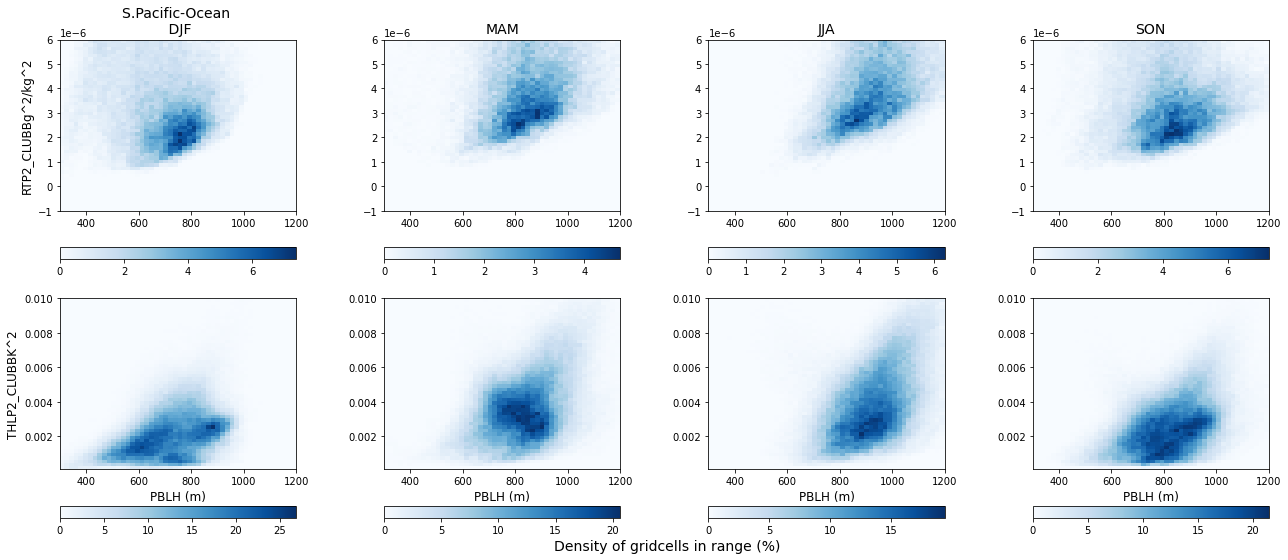

In [119]:
# Set up figure that plots U vs. LHFLX
fig, axs = plt.subplots(2,4, figsize=(18, 8))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X_rtp2,Y_rtp2   = np.meshgrid(PBLH_edges,RTP2_edges)
X_thlp2,Y_thlp2 = np.meshgrid(PBLH_edges,THLP2_edges)



# ------- Plot RTP2 relationship ----------------------------------------------

# Plot DJF 
pPlot = axs[0].pcolormesh(X_rtp2,Y_rtp2, 100.0*H_RTP2VSpblh_DJF,cmap='Blues')
fig.colorbar(pPlot,orientation='horizontal',ax=axs[0])

# Plot MAM 
pPlot=axs[1].pcolormesh(X_rtp2,Y_rtp2, 100*H_RTP2VSpblh_MAM,cmap='Blues')
# Use colorbar label only on bottom 
fig.colorbar(pPlot,orientation='horizontal',ax=axs[1])

# Plot JJA 
pPlot=axs[2].pcolormesh(X_rtp2,Y_rtp2, 100*H_RTP2VSpblh_JJA,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[2])


# Plot SON 
pPlot=axs[3].pcolormesh(X_rtp2,Y_rtp2, 100*H_RTP2VSpblh_SON,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[3])
    
# ------- Plot THLP2 relationship ----------------------------------------------

# Plot DJF 
pPlot = axs[4].pcolormesh(X_thlp2,Y_thlp2, 100.0*H_THLP2VSpblh_DJF,cmap='Blues')
fig.colorbar(pPlot,orientation='horizontal',ax=axs[4])

# Plot MAM 
pPlot=axs[5].pcolormesh(X_thlp2,Y_thlp2, 100*H_THLP2VSpblh_MAM,cmap='Blues')

# Use colorbar label only on bottom 
cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[5])
cb.set_label('Density of gridcells in range (%)',x=1.2,fontsize=14)

# Plot JJA 
pPlot=axs[6].pcolormesh(X_thlp2,Y_thlp2, 100*H_THLP2VSpblh_JJA,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[6])

# Plot SON 
pPlot=axs[7].pcolormesh(X_thlp2,Y_thlp2, 100*H_THLP2VSpblh_SON,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[7])

    
# ----------------------------------------------

# Set plot titles 

axs[0].set_title(RegMask.names.values[iReg][0]+' \n DJF',fontsize=14)
axs[1].set_title('MAM',fontsize=14)
axs[2].set_title('JJA',fontsize=14)
axs[3].set_title('SON',fontsize=14)
        
# Set axis labels only for outside plots 
axs[0].set_ylabel('RTP2_CLUBB'+dsAll.RTP2_CLUBB.units,fontsize=12)
axs[4].set_ylabel('THLP2_CLUBB'+dsAll.THLP2_CLUBB.units,fontsize=12)
    
axs[4].set_xlabel('PBLH (m)', fontsize=12)
axs[5].set_xlabel('PBLH (m)', fontsize=12)
axs[6].set_xlabel('PBLH (m)', fontsize=12)
axs[7].set_xlabel('PBLH (m)', fontsize=12)  

plt.tight_layout(h_pad=1)

    

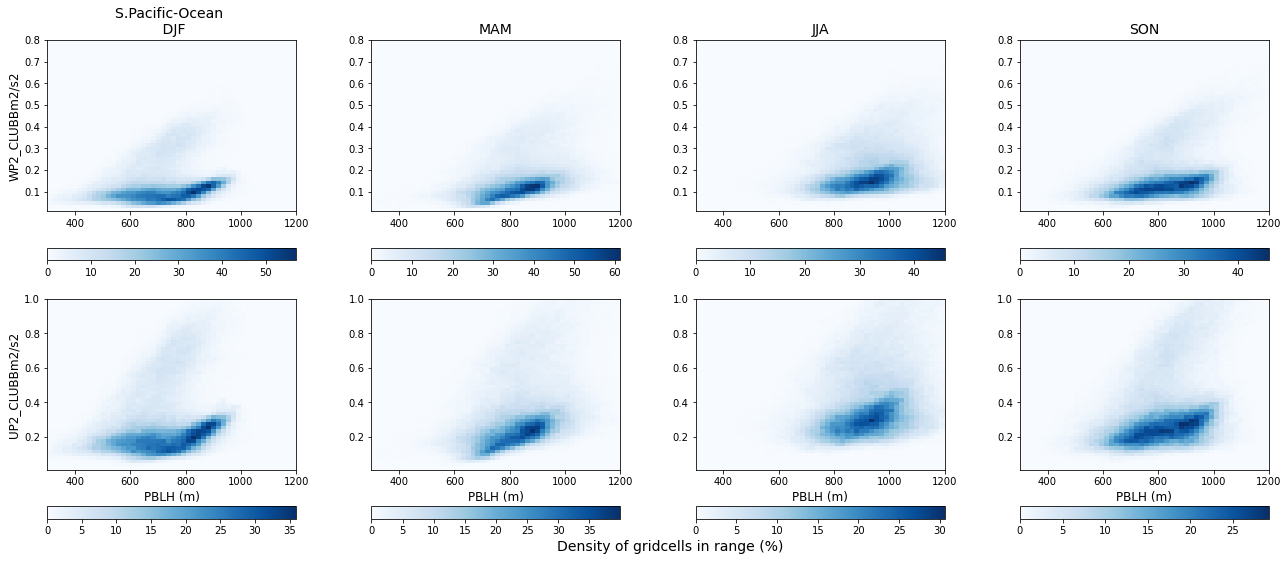

In [120]:
# Set up figure that plots U vs. LHFLX
fig, axs = plt.subplots(2,4, figsize=(18, 8))
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
#Put axs handles in array, axs 
axs = axs.ravel()

# Get X,Y=binedges as meshgrid for plotting purposes 
X_wp2,Y_wp2   = np.meshgrid(PBLH_edges,WP2_edges)
X_up2,Y_up2   = np.meshgrid(PBLH_edges,UP2_edges)


# ------- Plot WP2 relationship ----------------------------------------------

# Plot DJF 
pPlot = axs[0].pcolormesh(X_wp2,Y_wp2, 100.0*H_WP2VSpblh_DJF,cmap='Blues')
fig.colorbar(pPlot,orientation='horizontal',ax=axs[0])

# Plot MAM 
pPlot=axs[1].pcolormesh(X_wp2,Y_wp2, 100*H_WP2VSpblh_MAM,cmap='Blues')
# Use colorbar label only on bottom 
fig.colorbar(pPlot,orientation='horizontal',ax=axs[1])

# Plot JJA 
pPlot=axs[2].pcolormesh(X_wp2,Y_wp2, 100*H_WP2VSpblh_JJA,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[2])

# Plot SON 
pPlot=axs[3].pcolormesh(X_wp2,Y_wp2, 100*H_WP2VSpblh_SON,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[3])
    
# ------- Plot UP2 relationship ----------------------------------------------

# Plot DJF 
pPlot = axs[4].pcolormesh(X_up2,Y_up2, 100.0*H_UP2VSpblh_DJF,cmap='Blues')
fig.colorbar(pPlot,orientation='horizontal',ax=axs[4])

# Plot MAM 
pPlot=axs[5].pcolormesh(X_up2,Y_up2, 100*H_UP2VSpblh_MAM,cmap='Blues')

# Use colorbar label only on bottom 
cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[5])
cb.set_label('Density of gridcells in range (%)',x=1.2,fontsize=14)

# Plot JJA 
pPlot=axs[6].pcolormesh(X_up2,Y_up2, 100*H_UP2VSpblh_JJA,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[6])

# Plot SON 
pPlot=axs[7].pcolormesh(X_up2,Y_up2, 100*H_UP2VSpblh_SON,cmap='Blues')
fig.colorbar(pPlot, orientation='horizontal',ax=axs[7])

    
# ----------------------------------------------

# Set plot titles 

axs[0].set_title(RegMask.names.values[iReg][0]+' \n DJF',fontsize=14)
axs[1].set_title('MAM',fontsize=14)
axs[2].set_title('JJA',fontsize=14)
axs[3].set_title('SON',fontsize=14)
        
# Set axis labels only for outside plots 
axs[0].set_ylabel('WP2_CLUBB'+dsAll.WP2_CLUBB.units,fontsize=12)
axs[4].set_ylabel('UP2_CLUBB'+dsAll.UP2_CLUBB.units,fontsize=12)
    
axs[4].set_xlabel('PBLH (m)', fontsize=12)
axs[5].set_xlabel('PBLH (m)', fontsize=12)
axs[6].set_xlabel('PBLH (m)', fontsize=12)
axs[7].set_xlabel('PBLH (m)', fontsize=12)  

plt.tight_layout(h_pad=1)

    
    
    

## CLUBB variables, but sorted by color related to flux bias?

### Using a custom 2D histogram option?

In [209]:
'''
Make a function that plots regional scatter plots by season to represent relationships between three variables. 

Inputs:
   xVar:                     variable on x-axis
   yVar:                     variable on y-axis 
   cVar:                     variable to base coloring on 
   edgeX:                    BinEdges to use for xVar
   edgeY:                    BinEdges to use for yVar 
   xLabel:                   x-axis label 
   yLabel:                   y-axis label
   cLabel:                   color bar label 
   iDJF, iMAM, iJJA, iSON:   time indices for seasons to index xVar, yVar, and cVar
   cMin, cMax:               vmin and vmax values for cVar
   regOffset:                Based on above approach. For oceans there are 15 regions, 
                             5 plotted at a time, so this can be 0,1,2. 
   absVal_cVar:              Logical to use absolute value of cVar or not 
   histOpt:                  Valid options: 'count','bias' (what to use for shading in plots)

'''

def hist_2Dcustom(xVar, yVar, cVar, 
                       edgeX,edgeY,
                       xLabel, yLabel, cLabel, 
                       iDJF, iMAM, iJJA, iSON,
                       cMin,cMax,
                       regOffset, absVal_cVar, histOpt): 
    
    if absVal_cVar=='True':
        cVar = abs(cVar)
        cMapSel = 'Purples'
    else:
        cMapSel = 'seismic'
        
    if histOpt=='count':
        cMapSel='Blues'

    # Set up figure with multiple sub-panels 
    fig, axs = plt.subplots(5,4, figsize=(18, 18))
    fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
    axs = axs.ravel()
        
    # To change plot index by season as well as region
    pltInd    = 0   
    regOffset = 5*regOffset     # To change group of regions being plotted (increments of 4) 

    for iReg in range(5):
    
        # Select a region: 
        # - - - - - - - - - - 
        rSel = RegMask.sel(region=RegMask.region[iReg+regOffset])
        rMask = np.full([len(lat),len(lon)],np.nan)
        rMask[rSel==True] = 1 

        # Make mask 3D so that it can be multiplied with actual arrays of PBLH and bias...
        rMask_3d = rMask[np.newaxis,:,:]
        
        # Get seasonal/regional arrays based on averaging choice 

        xVar_DJF = xVar[iDJF,:,:]*rMask_3d
        yVar_DJF = yVar[iDJF,:,:]*rMask_3d
        cVar_DJF = cVar[iDJF,:,:]*rMask_3d           

        xVar_MAM = xVar[iMAM,:,:]*rMask_3d
        yVar_MAM = yVar[iMAM,:,:]*rMask_3d
        cVar_MAM = cVar[iMAM,:,:]*rMask_3d 

        xVar_JJA = xVar[iJJA,:,:]*rMask_3d
        yVar_JJA = yVar[iJJA,:,:]*rMask_3d
        cVar_JJA = cVar[iJJA,:,:]*rMask_3d 

        xVar_SON = xVar[iSON,:,:]*rMask_3d
        yVar_SON = yVar[iSON,:,:]*rMask_3d
        cVar_SON = cVar[iSON,:,:]*rMask_3d 
        
        
        # ------- Get bin means of cVar ----------
        
        meanC_per_bin_DJF = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        count_per_bin_DJF = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        
        meanC_per_bin_MAM = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        count_per_bin_MAM = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        
        meanC_per_bin_JJA = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        count_per_bin_JJA = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        
        meanC_per_bin_SON = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)
        count_per_bin_SON = np.full([len(edgeX)-1,len(edgeY)-1], np.nan)

        for ixBin in range(len(edgeX)-1):
            iSelX_DJF     = np.where((xVar_DJF>=edgeX[ixBin]) & (xVar_DJF<edgeX[ixBin+1]))
            selX_xVar_DJF = xVar_DJF[iSelX_DJF]
            selX_yVar_DJF = yVar_DJF[iSelX_DJF]
            selX_cVar_DJF = cVar_DJF[iSelX_DJF]
            
            iSelX_MAM     = np.where((xVar_MAM>=edgeX[ixBin]) & (xVar_MAM<edgeX[ixBin+1]))
            selX_xVar_MAM = xVar_MAM[iSelX_MAM]
            selX_yVar_MAM = yVar_MAM[iSelX_MAM]
            selX_cVar_MAM = cVar_MAM[iSelX_MAM]
            
            iSelX_JJA     = np.where((xVar_JJA>=edgeX[ixBin]) & (xVar_JJA<edgeX[ixBin+1]))
            selX_xVar_JJA = xVar_JJA[iSelX_JJA]
            selX_yVar_JJA = yVar_JJA[iSelX_JJA]
            selX_cVar_JJA = cVar_JJA[iSelX_JJA]
            
            iSelX_SON     = np.where((xVar_SON>=edgeX[ixBin]) & (xVar_SON<edgeX[ixBin+1]))
            selX_xVar_SON = xVar_SON[iSelX_SON]
            selX_yVar_SON = yVar_SON[iSelX_SON]
            selX_cVar_SON = cVar_SON[iSelX_SON]

            for iyBin in range(len(edgeY)-1):
                iSelY_DJF = np.where((selX_yVar_DJF>=edgeY[iyBin]) & (selX_yVar_DJF<edgeY[iyBin+1]) )[0]
                selXY_xVar_DJF = selX_xVar_DJF[iSelY_DJF]
                selXY_yVar_DJF = selX_yVar_DJF[iSelY_DJF]
                selXY_cVar_DJF = selX_cVar_DJF[iSelY_DJF]
                
                iSelY_MAM = np.where((selX_yVar_MAM>=edgeY[iyBin]) & (selX_yVar_MAM<edgeY[iyBin+1]) )[0]
                selXY_xVar_MAM = selX_xVar_MAM[iSelY_MAM]
                selXY_yVar_MAM = selX_yVar_MAM[iSelY_MAM]
                selXY_cVar_MAM = selX_cVar_MAM[iSelY_MAM]
                
                iSelY_JJA = np.where((selX_yVar_JJA>=edgeY[iyBin]) & (selX_yVar_JJA<edgeY[iyBin+1]) )[0]
                selXY_xVar_JJA = selX_xVar_JJA[iSelY_JJA]
                selXY_yVar_JJA = selX_yVar_JJA[iSelY_JJA]
                selXY_cVar_JJA = selX_cVar_JJA[iSelY_JJA]
                
                iSelY_SON = np.where((selX_yVar_SON>=edgeY[iyBin]) & (selX_yVar_SON<edgeY[iyBin+1]) )[0]
                selXY_xVar_SON = selX_xVar_SON[iSelY_SON]
                selXY_yVar_SON = selX_yVar_SON[iSelY_SON]
                selXY_cVar_SON = selX_cVar_SON[iSelY_SON]

                meanC_per_bin_DJF[ixBin, iyBin] = np.nanmean(selXY_cVar_DJF)
                count_per_bin_DJF[ixBin, iyBin] = len(selXY_yVar_DJF)/np.nansum(rMask)
                
                meanC_per_bin_MAM[ixBin, iyBin] = np.nanmean(selXY_cVar_MAM)
                count_per_bin_MAM[ixBin, iyBin] = len(selXY_yVar_MAM)/np.nansum(rMask)
                
                meanC_per_bin_JJA[ixBin, iyBin] = np.nanmean(selXY_cVar_JJA)
                count_per_bin_JJA[ixBin, iyBin] = len(selXY_yVar_JJA)/np.nansum(rMask)
                
                meanC_per_bin_SON[ixBin, iyBin] = np.nanmean(selXY_cVar_SON)
                count_per_bin_SON[ixBin, iyBin] = len(selXY_yVar_SON)/np.nansum(rMask)


            
        # ------- Plot relationship ----------------------------------------------
        
        # Get X,Y=binedges as meshgrid for plotting purposes 
        X,Y   = np.meshgrid(edgeX,edgeY)
        
        if histOpt=='bias':

            # Plot DJF 
            pPlot = axs[pltInd+0].pcolormesh(X,Y, meanC_per_bin_DJF.T,
                                  vmin=cMin, vmax=cMax, cmap=cMapSel)
            fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])

            # Plot MAM
            pPlot = axs[pltInd+1].pcolormesh(X,Y, meanC_per_bin_MAM.T,
                                  vmin=cMin, vmax=cMax, cmap=cMapSel)
            # Use colorbar label only on bottom 
            cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
            if iReg==4:
                cb.set_label(cLabel,x=1.2,fontsize=14)

            # Plot JJA
            pPlot = axs[pltInd+2].pcolormesh(X,Y, meanC_per_bin_JJA.T,
                                  vmin=cMin, vmax=cMax, cmap=cMapSel)
            fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+2])

            # Plot SON
            pPlot = axs[pltInd+3].pcolormesh(X,Y, meanC_per_bin_SON.T,
                                  vmin=cMin, vmax=cMax, cmap=cMapSel)
            fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+3])
        elif histOpt=='count':
            # Plot DJF 
            pPlot = axs[pltInd+0].pcolormesh(X,Y, count_per_bin_DJF.T,
                                  cmap=cMapSel)
            fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])

            # Plot MAM
            pPlot = axs[pltInd+1].pcolormesh(X,Y, count_per_bin_MAM.T,
                                    cmap=cMapSel)
            # Use colorbar label only on bottom 
            cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
            if iReg==4:
                cb.set_label(cLabel,x=1.2,fontsize=14)

            # Plot JJA
            pPlot = axs[pltInd+2].pcolormesh(X,Y, count_per_bin_JJA.T,
                                  cmap=cMapSel)
            fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+2])

            # Plot SON
            pPlot = axs[pltInd+3].pcolormesh(X,Y, count_per_bin_SON.T,
                                  cmap=cMapSel)
            fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+3])


    
        # Set plot titles 
        if iReg==0:
            axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
            axs[pltInd+1].set_title('MAM',fontsize=14)
            axs[pltInd+2].set_title('JJA',fontsize=14)
            axs[pltInd+3].set_title('SON',fontsize=14)
        else:
            axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)


        # ----------------------------------------------

        # Set axis labels only for outside plots 
        axs[pltInd+0].set_ylabel(yLabel,fontsize=12)

        if iReg==4: 
            axs[pltInd+0].set_xlabel(xLabel, fontsize=12)
            axs[pltInd+1].set_xlabel(xLabel, fontsize=12)
            axs[pltInd+2].set_xlabel(xLabel, fontsize=12)
            axs[pltInd+3].set_xlabel(xLabel, fontsize=12)  
        
        plt.tight_layout(h_pad=1)

        # Increment plot index for next region 
        pltInd = pltInd+4
    
    plt.show()


In [241]:
np.nanmean(sfcWP3)


0.00040729129

In [242]:
# Set up bin edges for both vars
RTP2_edges   = np.linspace(0,1.2e-4,51)
THLP2_edges  = np.linspace(1e-4,0.4,51)
WP2_edges    = np.linspace(1e-2, 0.8, 51)
UP2_edges    = np.linspace(1e-2, 1.0, 51)
WP3_edges    = np.linspace(-0.01, 0.01, 51)

PBLH_edges   = np.linspace(300,1200,51)


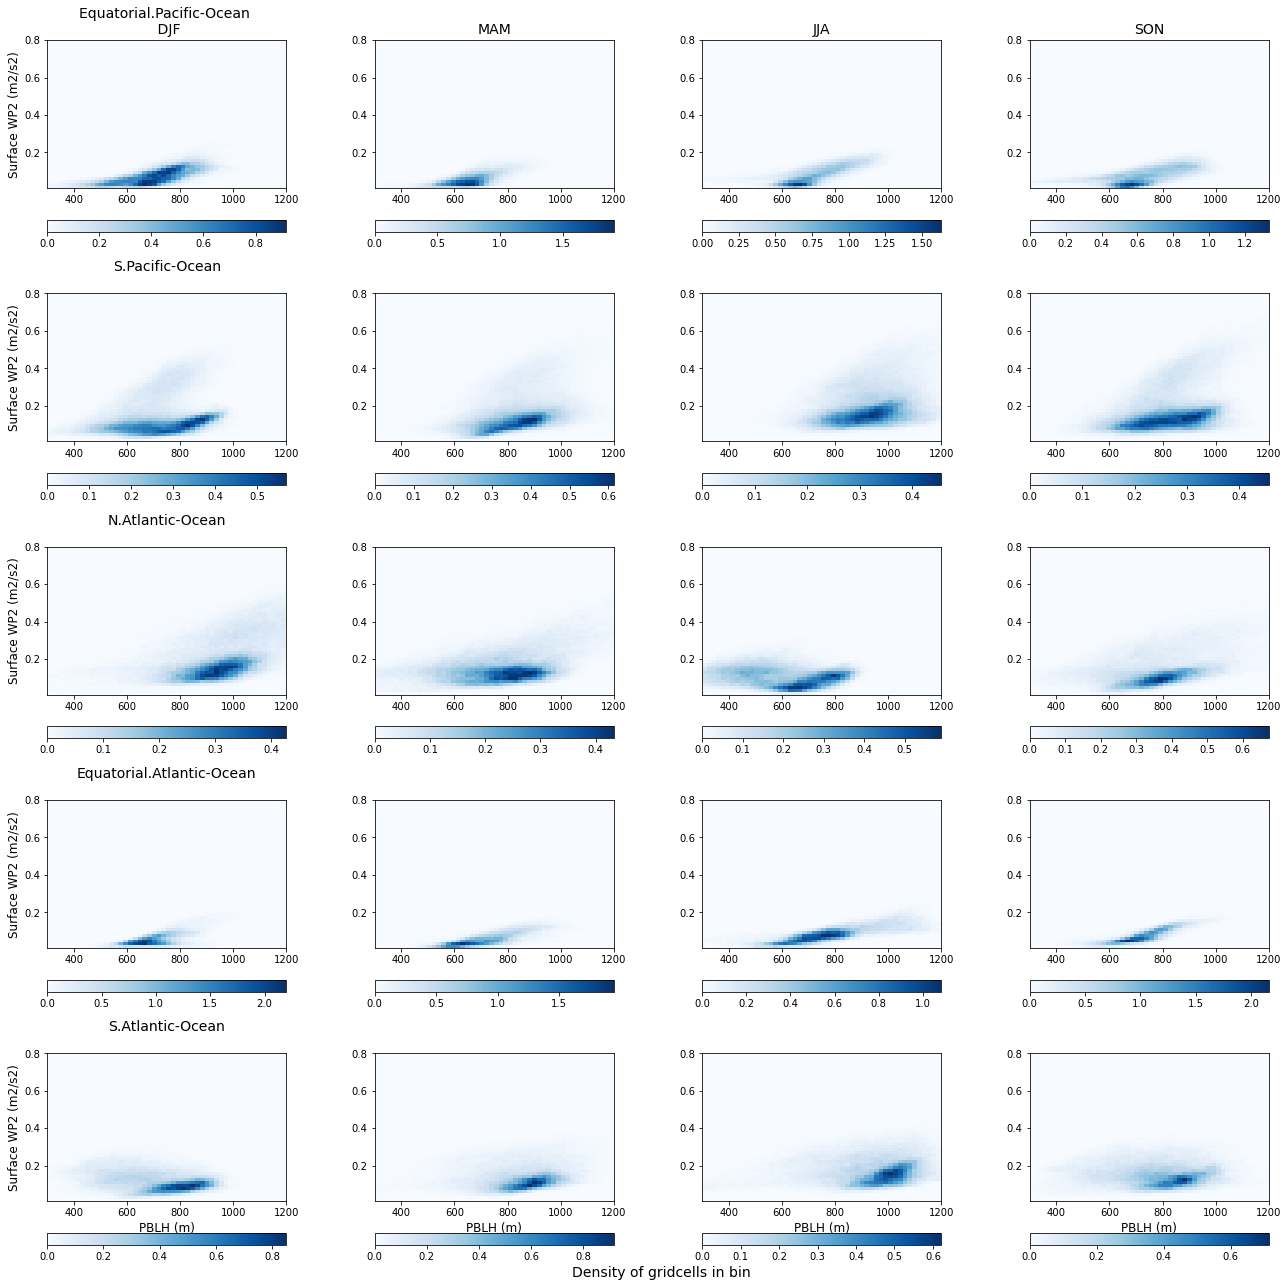

In [196]:
hist_2Dcustom(PBLH, sfcWP2, SHbias, 
              PBLH_edges,WP2_edges,
              'PBLH (m)', 'Surface WP2 (m2/s2)', 'Density of gridcells in bin', 
              iDJF, iMAM, iJJA, iSON,
              -20,
              20,
              1, 
              'False', 
              'count')

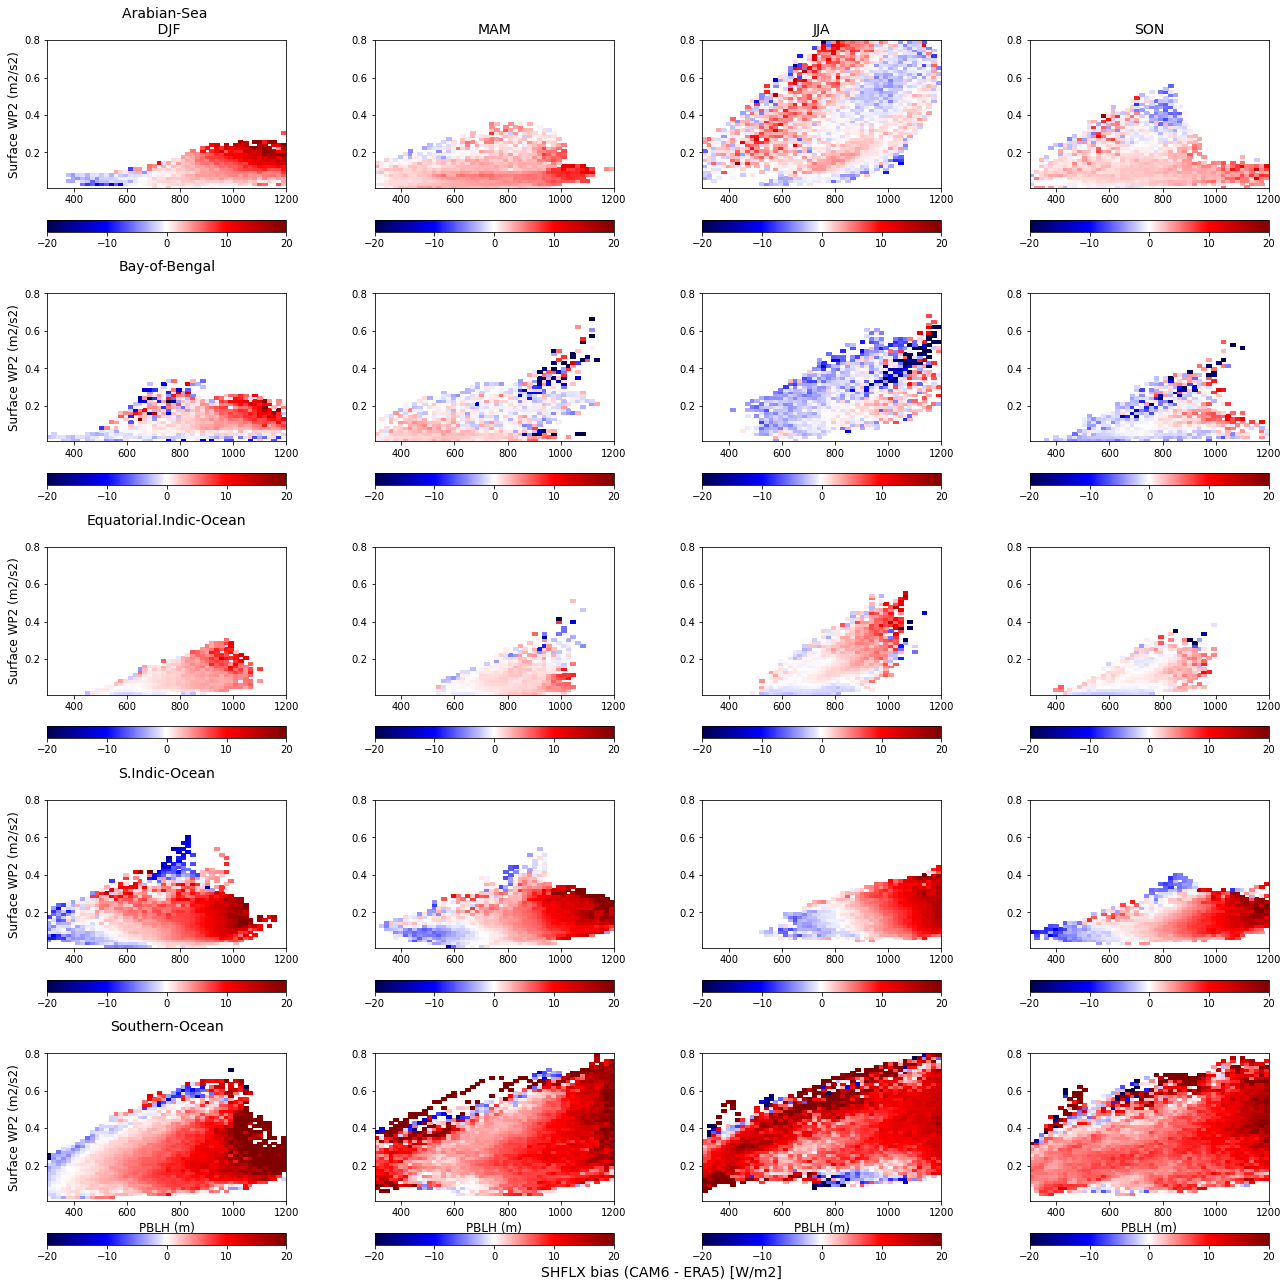

In [198]:
hist_2Dcustom(PBLH, sfcWP2, SHbias, 
              PBLH_edges,WP2_edges,
              'PBLH (m)', 'Surface WP2 (m2/s2)', 'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


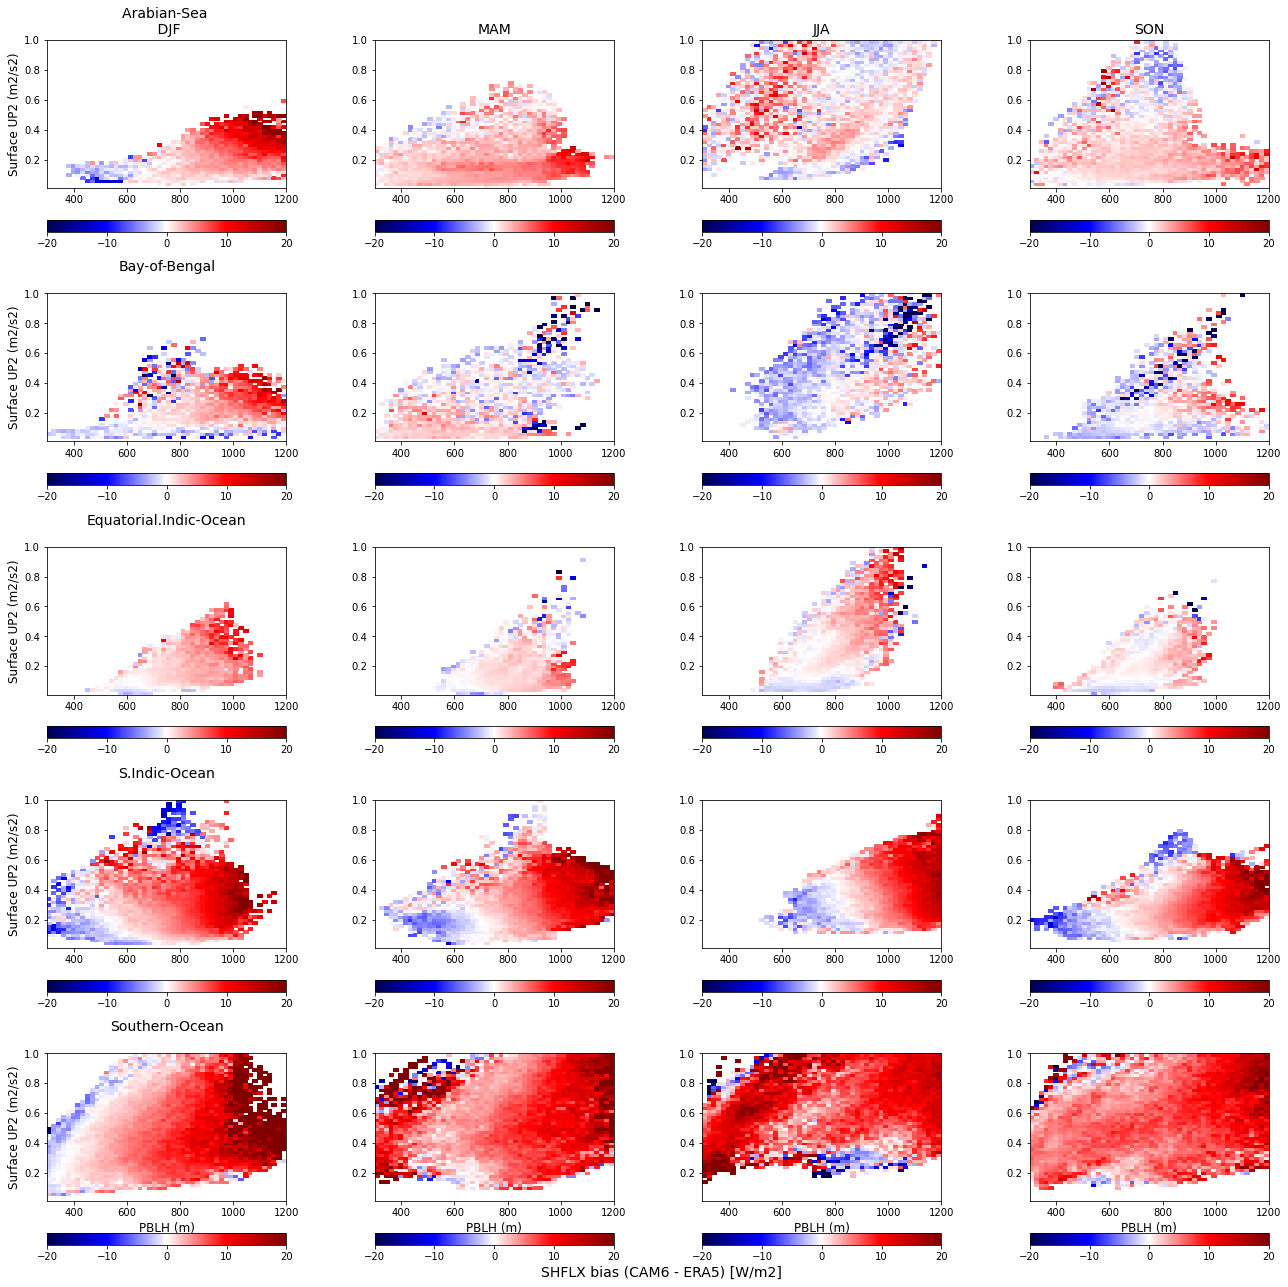

In [202]:
hist_2Dcustom(PBLH, sfcUP2, SHbias, 
              PBLH_edges,UP2_edges,
              'PBLH (m)', 'Surface UP2 (m2/s2)', 'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))



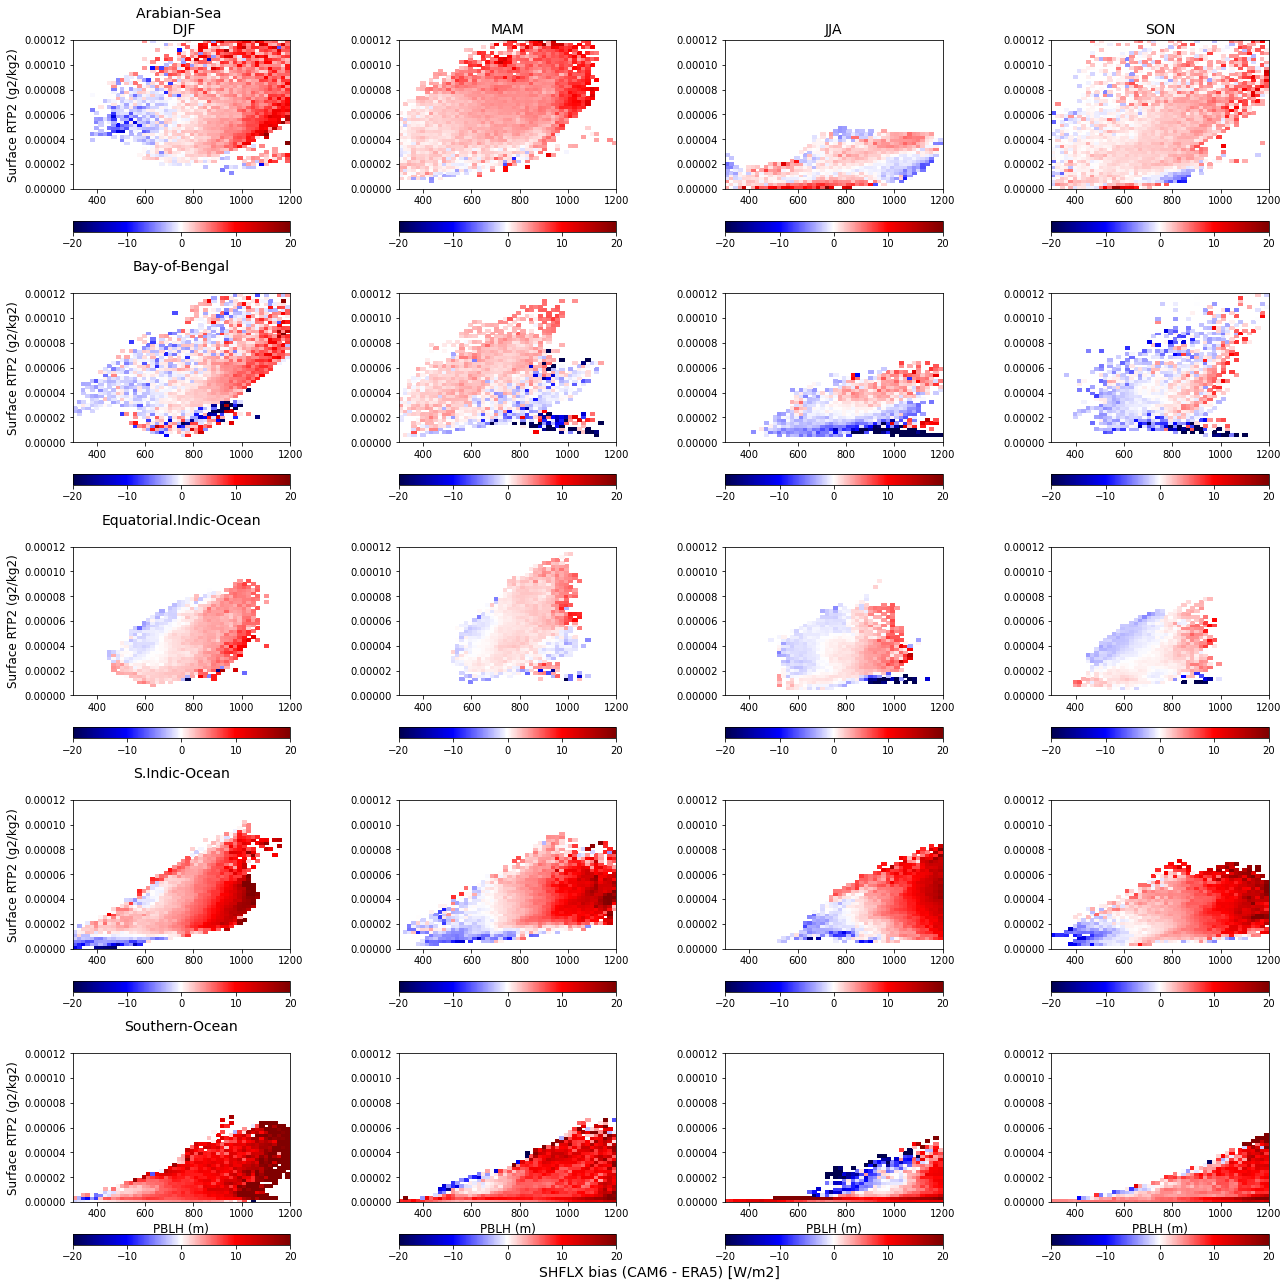

In [222]:
hist_2Dcustom(PBLH, sfcRTP2, SHbias, 
              PBLH_edges, RTP2_edges,
              'PBLH (m)', 'Surface RTP2 (g2/kg2)', 'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?  
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


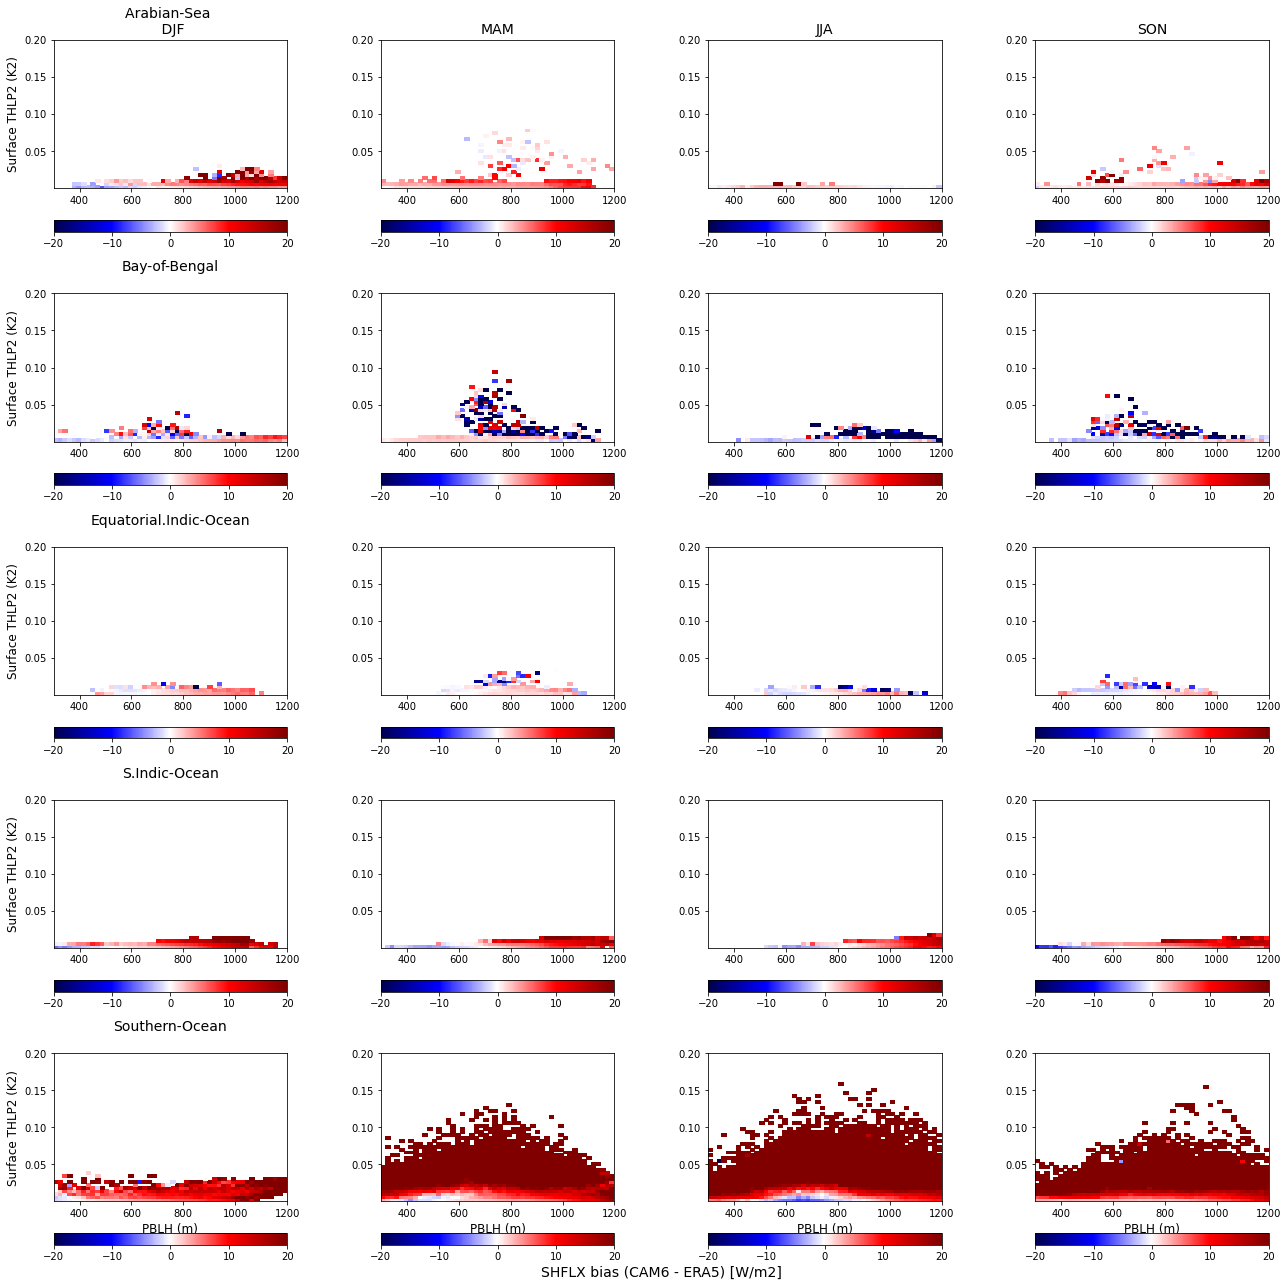

In [235]:
THLP2_edges  = np.linspace(1e-4,0.2,51)

hist_2Dcustom(PBLH, sfcTHLP2, SHbias, 
              PBLH_edges, THLP2_edges,
              'PBLH (m)', 'Surface THLP2 (K2)', 'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?  
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


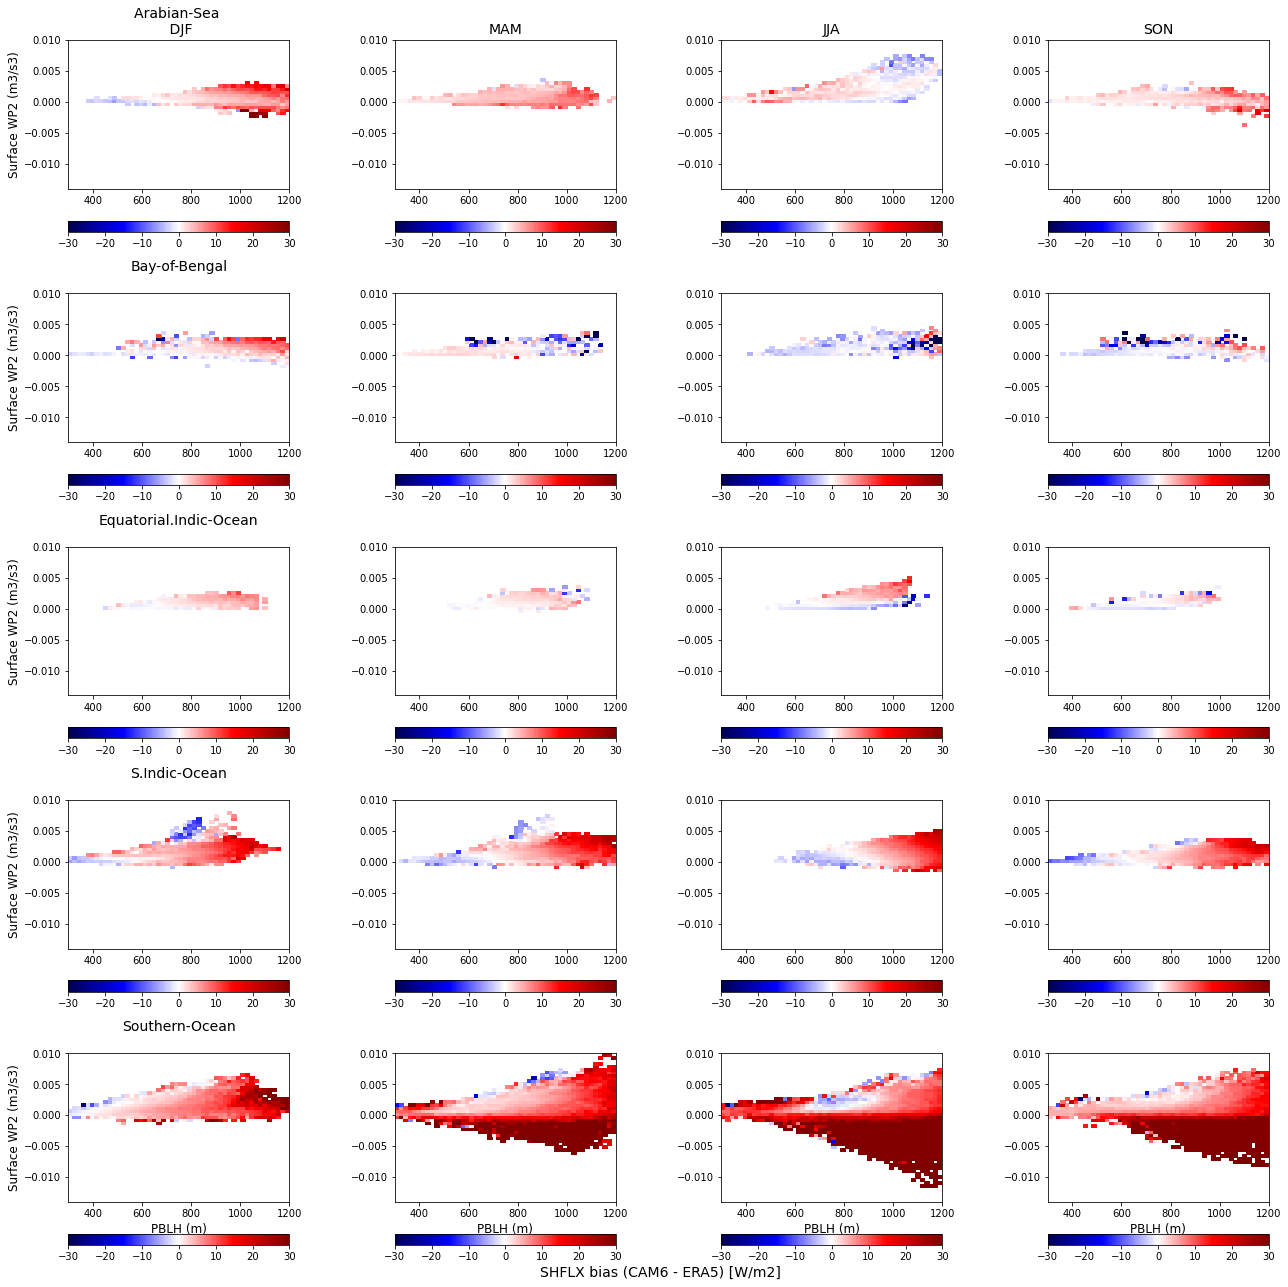

In [248]:
WP3_edges    = np.linspace(-0.014, 0.01, 51)

hist_2Dcustom(PBLH, sfcWP3, SHbias, 
              PBLH_edges,WP3_edges,
              'PBLH (m)', 'Surface WP2 (m3/s3)', 'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -30,         #cMin 
              30,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


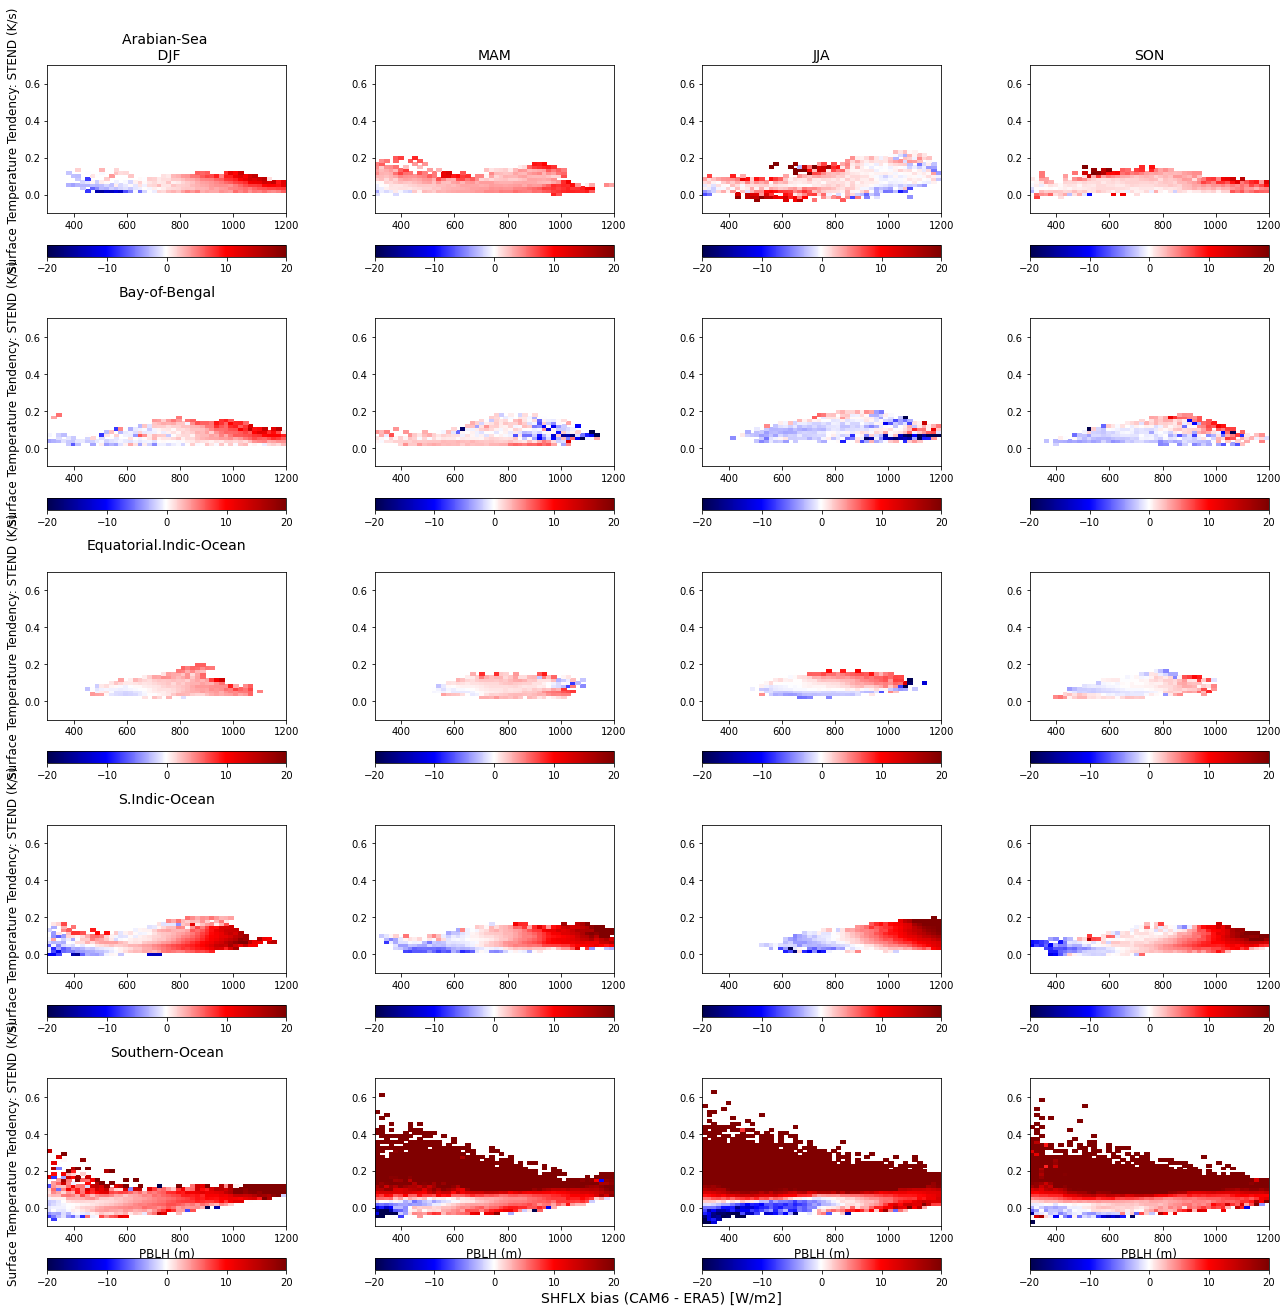

In [259]:
STEND_edges    = np.linspace(-0.1, 0.7, 51)

hist_2Dcustom(PBLH, sfcSTEND, SHbias, 
              PBLH_edges,STEND_edges,
              'PBLH (m)', 
              'Surface Temperature Tendency: STEND (K/s)', 
              'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


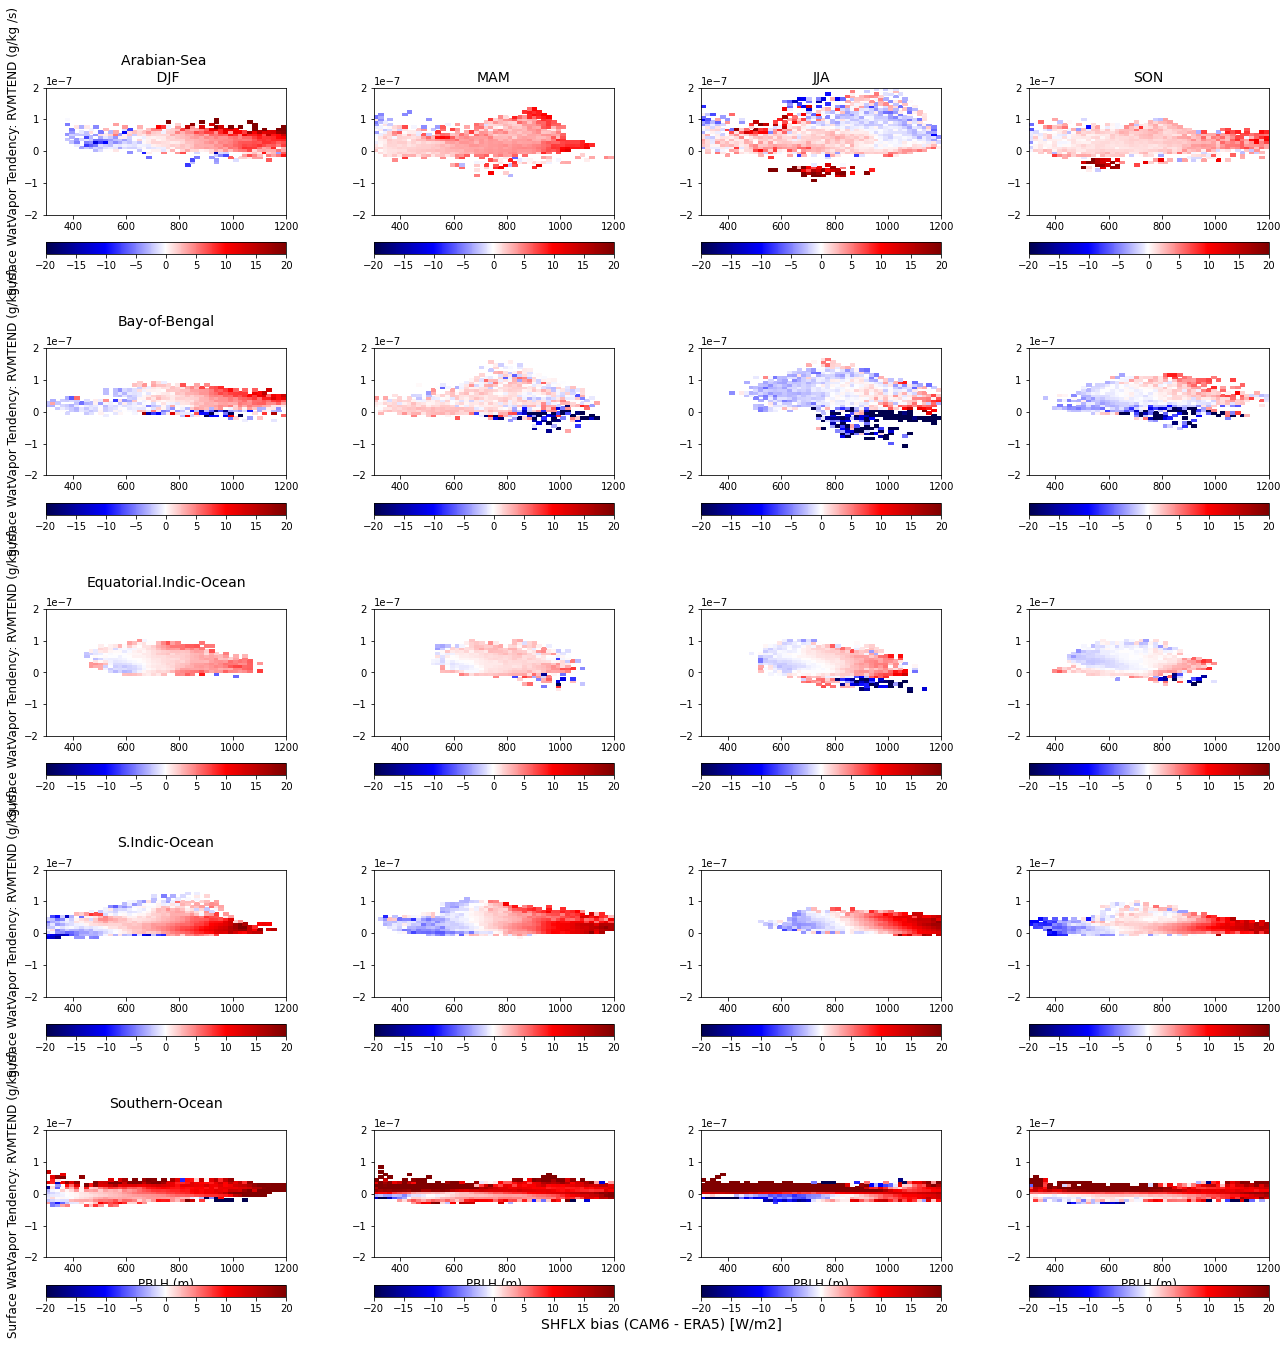

In [267]:
RVMTEND_edges    = np.linspace(-2e-7, 2e-7, 51)

hist_2Dcustom(PBLH, sfcRVMTEND, SHbias, 
              PBLH_edges,RVMTEND_edges,
              'PBLH (m)', 
              'Surface WatVapor Tendency: RVMTEND (g/kg /s)', 
              'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


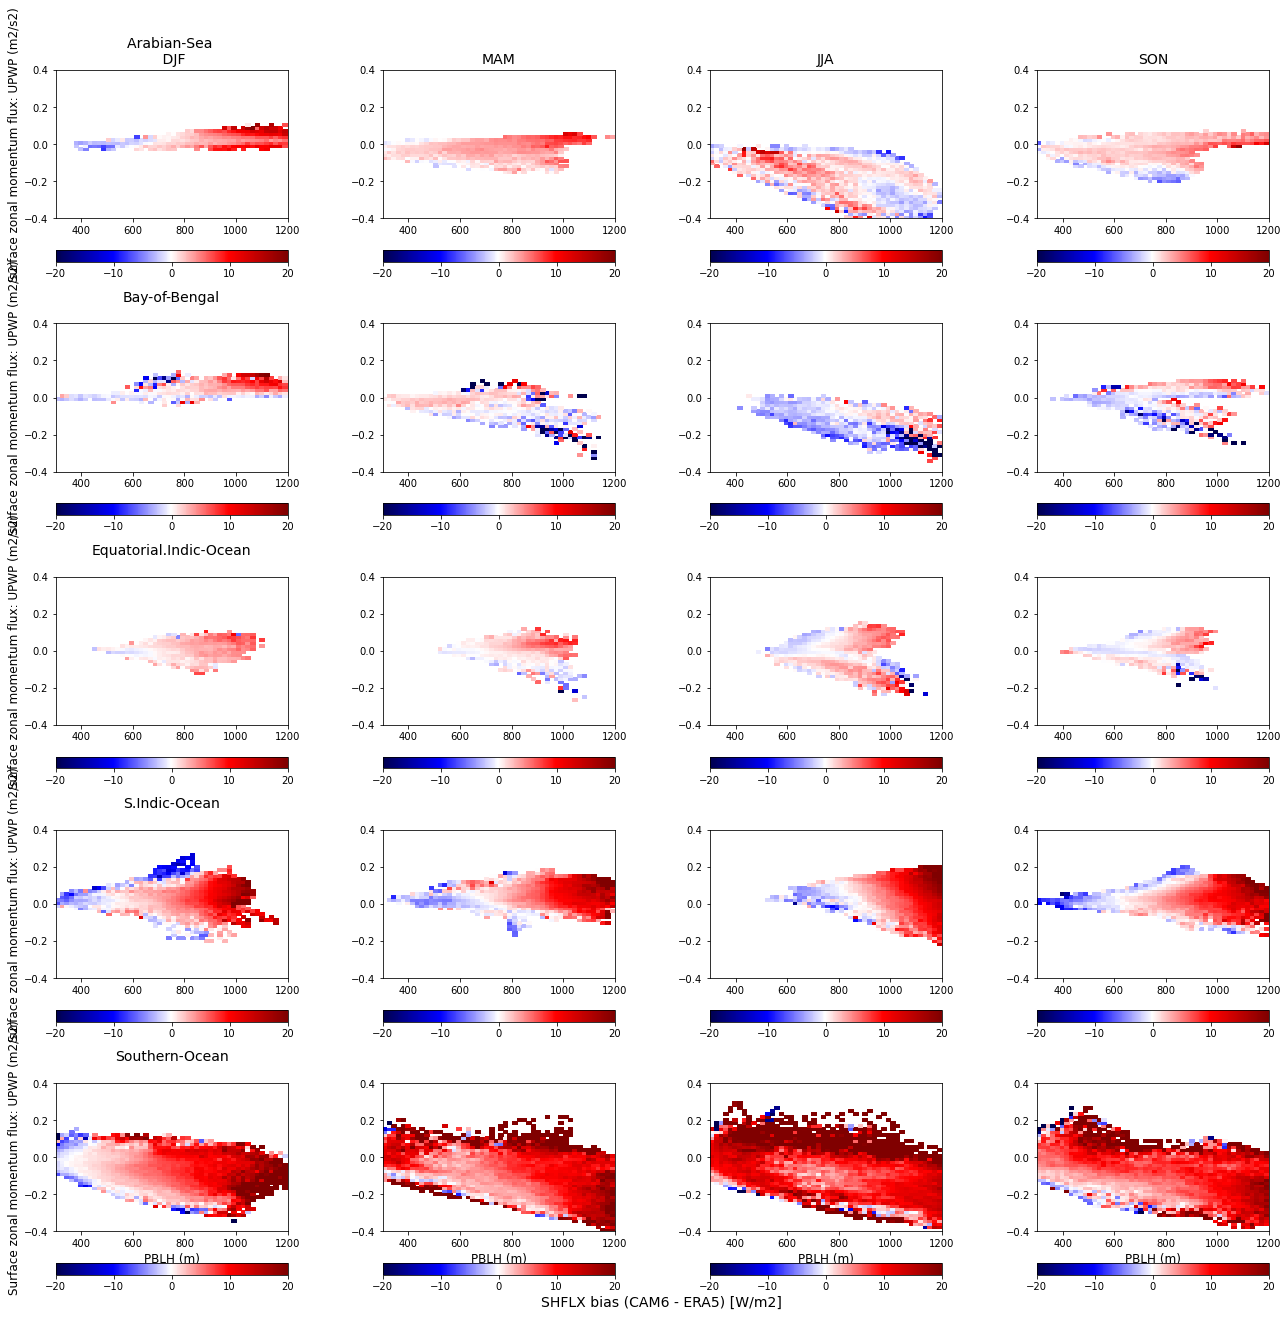

In [283]:
UPWP_edges    = np.linspace(-0.4, 0.4, 51)

hist_2Dcustom(PBLH, sfcUPWP, SHbias, 
              PBLH_edges,UPWP_edges,
              'PBLH (m)', 
              'Surface zonal momentum flux: UPWP (m2/s2)', 
              'SHFLX bias (CAM6 - ERA5) [W/m2]', 
              iDJF, iMAM, iJJA, iSON,
              -20,         #cMin 
              20,          #cMax
              2,           #Region offset
              'False',     #Use absolute value of bias?
              'bias')      #Which hist option to plot (density of points ('count') vs. flux bias ('bias'))


#### Original attempts using a scatter plot approach:

Helpful stack overflow question on how to make a scatter plot with the color of the points determined by a third variable: https://stackoverflow.com/questions/8202605/matplotlib-scatterplot-colour-as-a-function-of-a-third-variable

In [105]:
'''
Make a function that plots regional scatter plots by season to represent relationships between three variables. 

Inputs:
   xVar:                     variable on x-axis
   yVar:                     variable on y-axis 
   cVar:                     variable to base coloring on 
   xLabel:                   x-axis label 
   yLabel:                   y-axis label
   cLabel:                   color bar label 
   iDJF, iMAM, iJJA, iSON:   time indices for seasons to index xVar, yVar, and cVar
   cMin, cMax:               vmin and vmax values for cVar
   alphaLev:                 Alpha value to use for scatter plot points 
   regOffset:                Based on above approach. For oceans there are 15 regions, 
                             5 plotted at a time, so this can be 0,1,2. 
   absVal_cVar:              Logical to use absolute value of cVar or not 
   avgInTime:                Logical to specify averaging in time for all variables 

'''

def plotScatter_3Dinfo(xVar, yVar, cVar, 
                       xLabel, yLabel, cLabel, 
                       iDJF, iMAM, iJJA, iSON,
                       cMin,cMax,alphaLev,
                       regOffset, absVal_cVar, avgInTime): 
    
    if absVal_cVar=='True':
        cVar = abs(cVar)
        cMapSel = 'Purples'
    else:
        cMapSel = 'seismic'
        
    if avgInTime=='False':
        markerSize = 1
    else: 
        markerSize=20
    
    # Set up figure with multiple sub-panels 
    fig, axs = plt.subplots(5,4, figsize=(18, 18))
    fig.subplots_adjust(hspace = 0.4,wspace = 0.3)
    axs = axs.ravel()
        
    # To change plot index by season as well as region
    pltInd    = 0   
    regOffset = 5*regOffset     # To change group of regions being plotted (increments of 4) 

    for iReg in range(5):
    
        # Select a region: 
        # - - - - - - - - - - 
        rSel = RegMask.sel(region=RegMask.region[iReg+regOffset])
        rMask = np.full([len(lat),len(lon)],np.nan)
        rMask[rSel==True] = 1 

        # Make mask 3D so that it can be multiplied with actual arrays of PBLH and bias...
        rMask_3d = rMask[np.newaxis,:,:]
        
        # Get seasonal/regional arrays based on averaging choice 
        if avgInTime=='True':
            xVar_DJF = np.nanmean(xVar[iDJF,:,:]*rMask_3d,axis=0)
            yVar_DJF = np.nanmean(yVar[iDJF,:,:]*rMask_3d,axis=0)
            cVar_DJF = np.nanmean(cVar[iDJF,:,:]*rMask_3d,axis=0)
            
            xVar_MAM = np.nanmean(xVar[iMAM,:,:]*rMask_3d,axis=0)
            yVar_MAM = np.nanmean(yVar[iMAM,:,:]*rMask_3d,axis=0)
            cVar_MAM = np.nanmean(cVar[iMAM,:,:]*rMask_3d,axis=0)
            
            xVar_JJA = np.nanmean(xVar[iJJA,:,:]*rMask_3d,axis=0)
            yVar_JJA = np.nanmean(yVar[iJJA,:,:]*rMask_3d,axis=0)
            cVar_JJA = np.nanmean(cVar[iJJA,:,:]*rMask_3d,axis=0)
            
            xVar_SON = np.nanmean(xVar[iSON,:,:]*rMask_3d,axis=0)
            yVar_SON = np.nanmean(yVar[iSON,:,:]*rMask_3d,axis=0)
            cVar_SON = np.nanmean(cVar[iSON,:,:]*rMask_3d,axis=0)
            
        else:
            xVar_DJF = xVar[iDJF,:,:]*rMask_3d
            yVar_DJF = yVar[iDJF,:,:]*rMask_3d
            cVar_DJF = cVar[iDJF,:,:]*rMask_3d           

            xVar_MAM = xVar[iMAM,:,:]*rMask_3d
            yVar_MAM = yVar[iMAM,:,:]*rMask_3d
            cVar_MAM = cVar[iMAM,:,:]*rMask_3d 
            
            xVar_JJA = xVar[iJJA,:,:]*rMask_3d
            yVar_JJA = yVar[iJJA,:,:]*rMask_3d
            cVar_JJA = cVar[iJJA,:,:]*rMask_3d 
            
            xVar_SON = xVar[iSON,:,:]*rMask_3d
            yVar_SON = yVar[iSON,:,:]*rMask_3d
            cVar_SON = cVar[iSON,:,:]*rMask_3d 
            
        # ------- Plot relationship ----------------------------------------------
        
            
            
        # Plot DJF 
        pPlot=axs[pltInd+0].scatter(xVar_DJF[np.isfinite(xVar_DJF)],
                                    yVar_DJF[np.isfinite(yVar_DJF)], 
                                    s=markerSize,
                                    c=cVar_DJF[np.isfinite(cVar_DJF)], 
                                    vmin = cMin, vmax = cMax,
                                    alpha = alphaLev,
                                    cmap=cMapSel)
        fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+0])

        # Plot MAM 
        pPlot=axs[pltInd+1].scatter(xVar_MAM[np.isfinite(xVar_MAM)],
                                    yVar_MAM[np.isfinite(yVar_MAM)], 
                                    s=markerSize,
                                    c=cVar_MAM[np.isfinite(cVar_MAM)], 
                                    vmin = cMin, vmax = cMax,
                                    alpha = alphaLev,
                                    cmap=cMapSel)        
        # Use colorbar label only on bottom 
        cb=fig.colorbar(pPlot,orientation='horizontal',ax=axs[pltInd+1])
        if iReg==4:
            cb.set_label(cLabel,x=1.2,fontsize=14)

        # Plot JJA 
        pPlot=axs[pltInd+2].scatter(xVar_JJA[np.isfinite(xVar_JJA)],
                                    yVar_JJA[np.isfinite(yVar_JJA)], 
                                    s=markerSize,
                                    c=cVar_JJA[np.isfinite(cVar_JJA)], 
                                    vmin = cMin, vmax = cMax,
                                    alpha = alphaLev,
                                    cmap=cMapSel)
        fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+2])

        # Plot SON 
        pPlot=axs[pltInd+3].scatter(xVar_SON[np.isfinite(xVar_SON)],
                                    yVar_SON[np.isfinite(yVar_SON)], 
                                    s=markerSize,
                                    c=cVar_SON[np.isfinite(cVar_SON)], 
                                    vmin = cMin, vmax = cMax,
                                    alpha = alphaLev,
                                    cmap=cMapSel)
        fig.colorbar(pPlot, orientation='horizontal',ax=axs[pltInd+3])

        # Set plot titles 
        if iReg==0:
            if avgInTime=='True':
                axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF (timeMean)',fontsize=14)
                axs[pltInd+1].set_title('MAM (timeMean)',fontsize=14)
                axs[pltInd+2].set_title('JJA (timeMean)',fontsize=14)
                axs[pltInd+3].set_title('SON (timeMean)',fontsize=14)
            else: 
                axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+' \n DJF',fontsize=14)
                axs[pltInd+1].set_title('MAM',fontsize=14)
                axs[pltInd+2].set_title('JJA',fontsize=14)
                axs[pltInd+3].set_title('SON',fontsize=14)
        else:
            axs[pltInd+0].set_title(RegMask.names.values[iReg+regOffset]+'\n ', fontsize=14)


        # ----------------------------------------------

        # Set axis labels only for outside plots 
        axs[pltInd+0].set_ylabel(yLabel,fontsize=12)

        if iReg==4: 
            axs[pltInd+0].set_xlabel(xLabel, fontsize=12)
            axs[pltInd+1].set_xlabel(xLabel, fontsize=12)
            axs[pltInd+2].set_xlabel(xLabel, fontsize=12)
            axs[pltInd+3].set_xlabel(xLabel, fontsize=12)  
        
        plt.tight_layout(h_pad=1)

        # Increment plot index for next region 
        pltInd = pltInd+4
    
    plt.show()



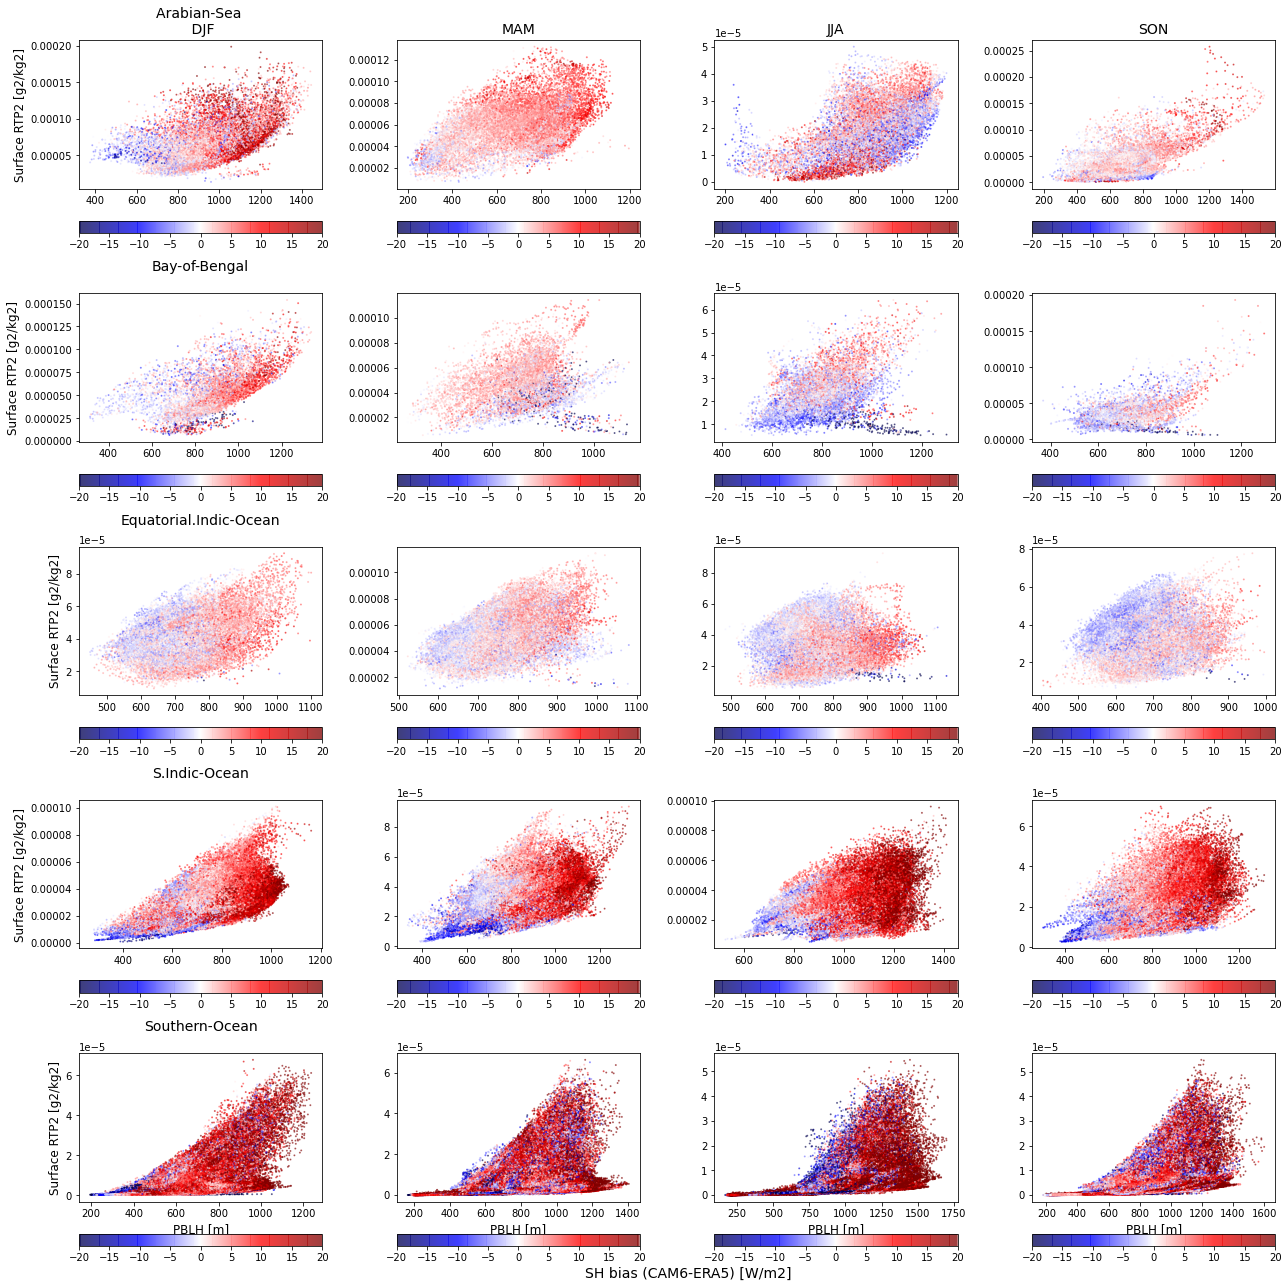

In [112]:
plotScatter_3Dinfo(PBLH, sfcRTP2, SHbias, 
                   'PBLH [m]', 'Surface RTP2 [g2/kg2]', 'SH bias (CAM6-ERA5) [W/m2]', 
                   iDJF, iMAM, iJJA, iSON,
                   -20,        # cMin
                   20,         # cMax
                   0.5,        # alphaLev
                   2,          # regOffset
                   'False',    # absVal_cVar
                   'False')    # avgInTime


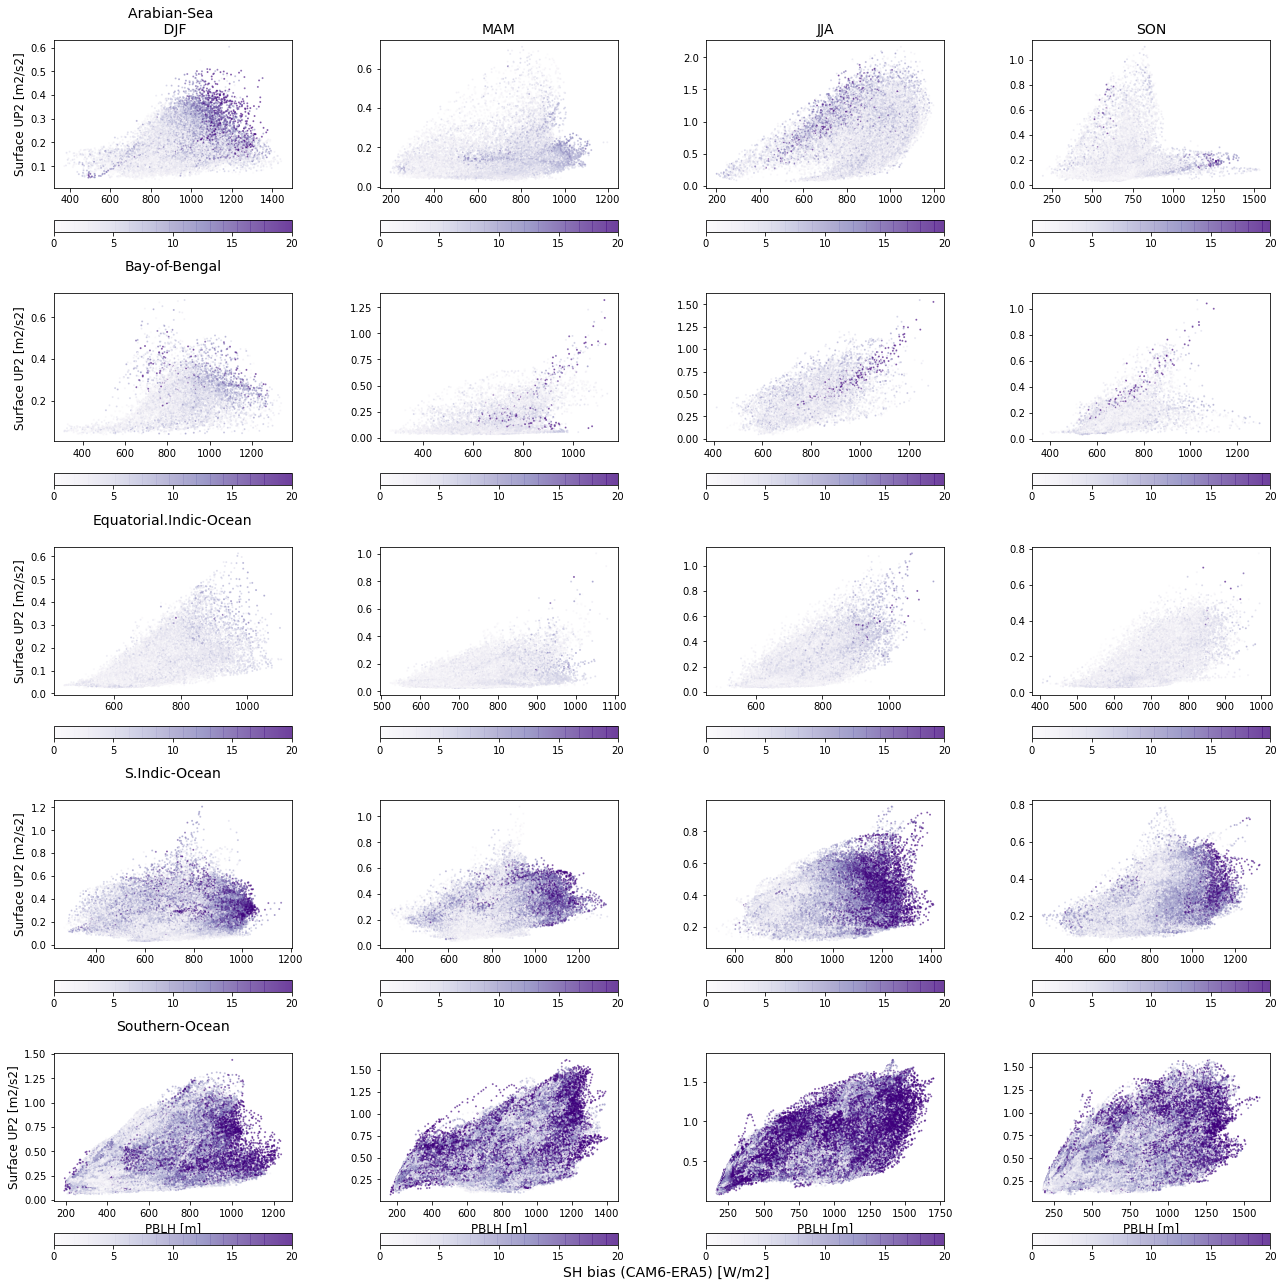

In [107]:
plotScatter_3Dinfo(PBLH, sfcRTP2, SHbias, 
                   'PBLH [m]', 'Surface RTP2 [g2/kg2]', 'SH bias (CAM6-ERA5) [W/m2]', 
                   iDJF, iMAM, iJJA, iSON,
                   0,          # cMin
                   20,         # cMax
                   0.5,        # alphaLev
                   2,          # regOffset
                   'True',     # absVal_cVar
                   'False')    # avgInTime